<hr style="border:2px solid gray">

##### Author  : SIVA VIKNESH 
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com 
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA 
<hr style="border:2px solid gray">

In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]
import vtk
from vtk.util import numpy_support as VN
from itertools import combinations

Periodically-damped oscillator:  <br>
Paper: Harmonic Oscillators with Nonlinear Damping
$$
\begin{aligned}
\dot{x} & = y \\
\dot{y} & = -x +a y \hspace{1.5mm}\text{cos}(bx)  \\
\end{aligned}
$$

Parameters: \\(a\\), \\(b\\)

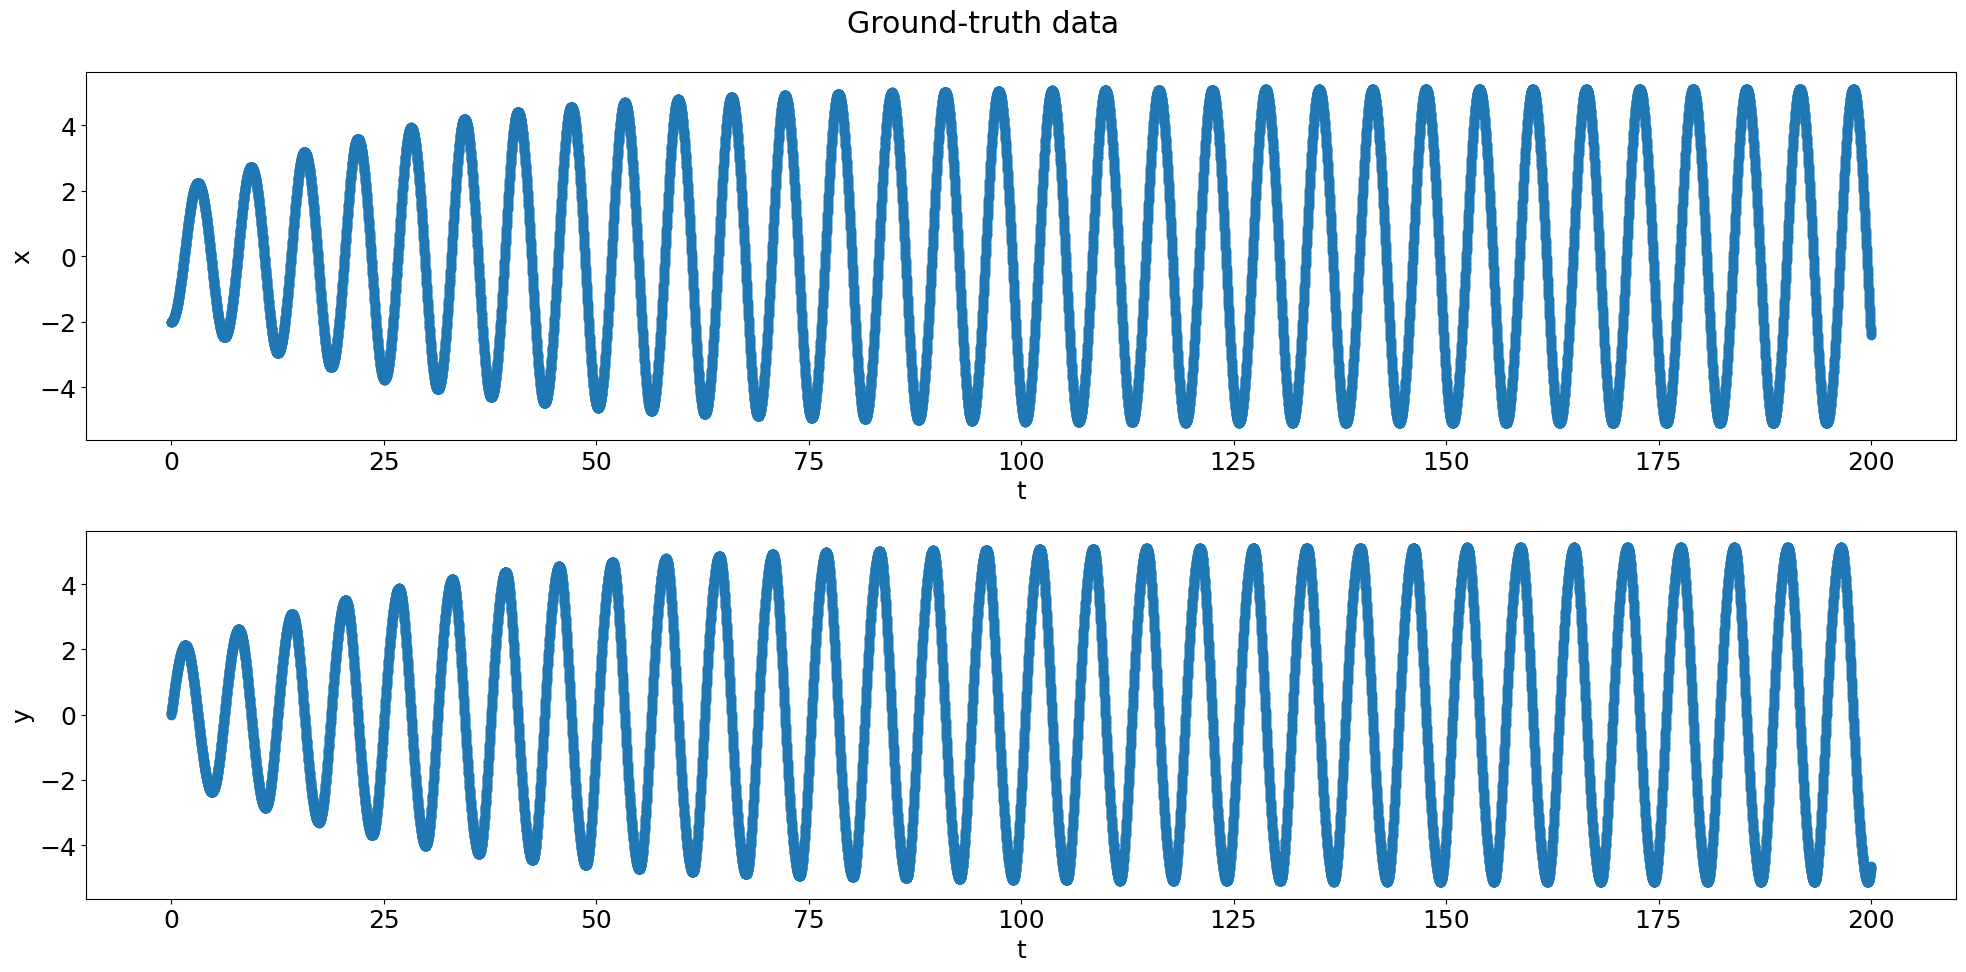

In [2]:
dt = 0.01
T = 200
t = np.arange(0,T+dt,dt)
a = -1.0
b =  0.1
c =  0.750


def oscillator_deriv(x_y, t0, a = a, b = b, c = c):
    x, y = x_y
    return [y, a*x +(b*y)*(np.cos(c*x))]

np.random.seed(123)
x0 = (-2, 0)
x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o') 
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o') 
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

fig.tight_layout()
plt.show()

In [3]:
# COMPUTING THE COMBINATIONS AMONG THE THREE CHOSEN TEMPORAL MODES

def POOL_DATA(yin, nVars, polyorder):
    n = yin.shape[0]
    yout = torch.zeros((n, 1)).to(processor)

    # poly order 0
    yout[:, 0] = torch.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = torch.cat((yout, yin[:, i].reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout = torch.cat((yout, (yin[:, i] * yin[:, j]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    yout = torch.cat((yout, (yin[:, i] * yin[:, j] * yin[:, k]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    return yout

def DERIVATIVE(x, y, a, b, c):
    dxdt = y
    dydt = a*x + b*y*torch.cos(c*x)    
    return torch.vstack((dxdt, dydt)).T


AVAILABLE PROCESSOR: cuda 



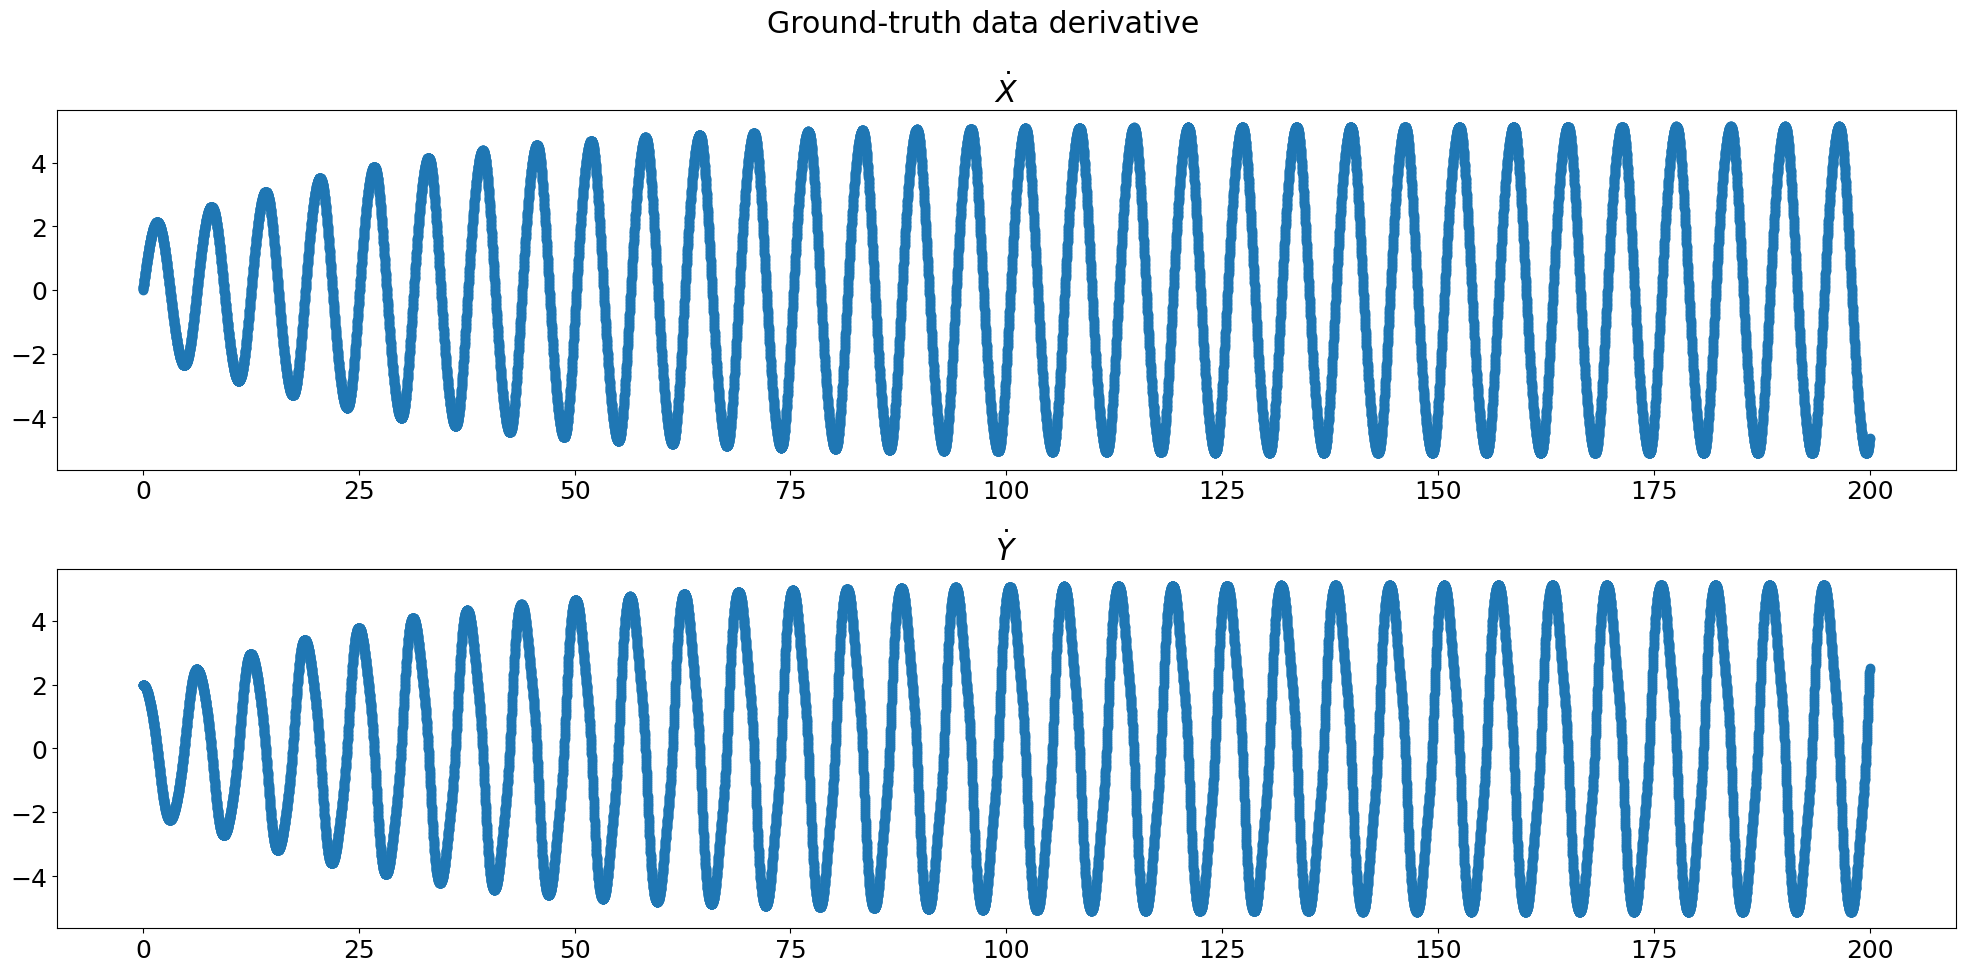

In [4]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

N_modes  = 2
x_t      = torch.Tensor(x_t).to(processor)
x        = torch.Tensor(x).to(processor)
y        = torch.Tensor(y).to(processor)
t        = torch.Tensor(t).to(processor)

A_candidates    = POOL_DATA (x_t, 2, 2).to(processor)
A1A2_time_deriv = DERIVATIVE (x, y, a, b, c).to(processor)

# HYPERPARAMETERS FOR THE SINDy POD METHODOLOGY
Epochs        = 40000
learning_rate = 1e-2
step_epoch    = 2500
decay_rate    = 0.50
                       

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 0].detach().cpu().numpy(), '-o') 
ax[0].set_title('$\dot{X}$')

ax[1].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 1].detach().cpu().numpy(), '-o') 
ax[1].set_title('$\dot{Y}$')

fig.tight_layout()
plt.show()

In [5]:
class SINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b
        
    def forward(self, x):
        output = torch.sin(self.b*x)
        return output
    
class COSINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b
        
    def forward(self, x):
        output = torch.cos(self.b*x)
        return output

In [6]:
class ADAPTIVE_SINDy_MODEL(nn.Module):
    def __init__(self, a, asine, acosine, axsine, axcosine):
        super().__init__()    
        self.a        = a
        self.asine    = asine
        self.acosine  = acosine
        self.axsine   = axsine
        self.axcosine = axcosine
        
        self.sine     = SINE_TERM   (self.asine)
        self.cosine   = COSINE_TERM (self.acosine)
        self.xsine    = SINE_TERM   (self.axsine)
        self.xcosine  = COSINE_TERM (self.axcosine)
        
    def forward(self, x):
        output_sine    = self.sine   (x)
        output_cosine  = self.cosine (x)

        output_xsine   = self.xsine   (x)
        output_xcosine = self.xcosine (x)
 
        output_xsine   = (output_xsine  [:,None] * x[...,None]).reshape(x.shape[0], -1)
        output_xcosine = (output_xcosine[:,None] * x[...,None]).reshape(x.shape[0], -1)
        
        output = torch.hstack((x, output_sine, output_cosine, output_xsine, output_xcosine)) @ self.a
        return output


In [7]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(90, N_modes, requires_grad= True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)
XSINE_ADT   = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)

In [8]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, SINE_ADT, COSINE_ADT, XSINE_ADT, XCOSINE_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
Lambda   = Parameter(torch.tensor(1.0), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda],  lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)


**Adaptive SINDy training**

In [9]:
# TEMPORAL MODE 1
A1_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0], XSINE_ADT [:, 0], XCOSINE_ADT[:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1], XSINE_ADT [:, 1], XCOSINE_ADT[:, 1]).to(processor)

Loss_data     = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    A1_out, A2_out  = A1_DT (A_candidates), A2_DT (A_candidates)
    output_data  = torch.stack((A1_out , A2_out), dim = 1)
    loss_epoch   = loss_function (A1A2_time_deriv, output_data) + torch.linalg.matrix_norm(torch.abs(WEIGHTS)*COEFF_ADT, ord =1)
    
    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    optim_weights.zero_grad()
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()
        optim_weights.step()
        Loss_data [epoch] = loss_epoch.detach()
        COEFF_ADT [torch.abs(COEFF_ADT) <= 0.0075] = 0.0
        
    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)
       
    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

LOSS DATA, [EPOCH = 0 ]: 8786.83203125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1 ]: 7561.57470703125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2 ]: 6423.4248046875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3 ]: 5446.36572265625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4 ]: 4676.8125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 5 ]: 4123.35986328125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 6 ]: 3754.27587890625
LEARNING RATE: 0.01
*************************************************************

LOSS DATA, [EPOCH = 74 ]: 274.67779541015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 75 ]: 270.7053527832031
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 76 ]: 266.8058166503906
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 77 ]: 262.99102783203125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 78 ]: 259.2701110839844
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 79 ]: 255.80783081054688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 80 ]: 252.4530487060547
LEARNING RATE: 0.01
*********************************

LOSS DATA, [EPOCH = 143 ]: 119.45760345458984
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 144 ]: 118.0089111328125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 145 ]: 116.59602355957031
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 146 ]: 115.17320251464844
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 147 ]: 113.7814712524414
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 148 ]: 112.42235565185547
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 149 ]: 111.0873031616211
LEARNING RATE: 0.01
*************************

LOSS DATA, [EPOCH = 216 ]: 51.70927047729492
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 217 ]: 51.11237335205078
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 218 ]: 50.51047897338867
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 219 ]: 49.94588851928711
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 220 ]: 49.37753677368164
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 221 ]: 48.816131591796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 222 ]: 48.25448226928711
LEARNING RATE: 0.01
****************************

LOSS DATA, [EPOCH = 287 ]: 22.695838928222656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 288 ]: 22.442251205444336
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 289 ]: 22.197179794311523
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 290 ]: 21.958667755126953
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 291 ]: 21.71729850769043
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 292 ]: 21.486953735351562
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 293 ]: 21.24895668029785
LEARNING RATE: 0.01
************************

LOSS DATA, [EPOCH = 359 ]: 11.34893798828125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 360 ]: 11.266507148742676
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 361 ]: 11.180516242980957
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 362 ]: 11.095210075378418
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 363 ]: 11.016636848449707
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 364 ]: 10.934747695922852
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 365 ]: 10.858315467834473
LEARNING RATE: 0.01
***********************

LOSS DATA, [EPOCH = 430 ]: 7.216325759887695
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 431 ]: 7.173699855804443
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 432 ]: 7.1317315101623535
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 433 ]: 7.098968505859375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 434 ]: 7.062727451324463
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 435 ]: 7.024446964263916
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 436 ]: 6.988387584686279
LEARNING RATE: 0.01
****************************

LOSS DATA, [EPOCH = 503 ]: 4.889890670776367
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 504 ]: 4.858458995819092
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 505 ]: 4.828240394592285
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 506 ]: 4.80591344833374
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 507 ]: 4.774179458618164
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 508 ]: 4.752302169799805
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 509 ]: 4.721232891082764
LEARNING RATE: 0.01
******************************

LOSS DATA, [EPOCH = 574 ]: 3.1572206020355225
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 575 ]: 3.1352524757385254
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 576 ]: 3.1103997230529785
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 577 ]: 3.092451572418213
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 578 ]: 3.06649112701416
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 579 ]: 3.0552895069122314
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 580 ]: 3.0330941677093506
LEARNING RATE: 0.01
*************************

LOSS DATA, [EPOCH = 647 ]: 1.7987388372421265
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 648 ]: 1.7927552461624146
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 649 ]: 1.7734289169311523
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 650 ]: 1.7573732137680054
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 651 ]: 1.7403308153152466
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 652 ]: 1.7240625619888306
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 653 ]: 1.703553557395935
LEARNING RATE: 0.01
***********************

LOSS DATA, [EPOCH = 719 ]: 0.916767418384552
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 720 ]: 0.9015300273895264
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 721 ]: 0.884835422039032
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 722 ]: 0.8763851523399353
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 723 ]: 0.8665622472763062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 724 ]: 0.8592322468757629
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 725 ]: 0.848335325717926
LEARNING RATE: 0.01
*************************

LOSS DATA, [EPOCH = 793 ]: 0.41140294075012207
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 794 ]: 0.40327832102775574
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 795 ]: 0.4024401903152466
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 796 ]: 0.4007374048233032
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 797 ]: 0.39432811737060547
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 798 ]: 0.3875587284564972
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 799 ]: 0.3801976442337036
LEARNING RATE: 0.01
*******************

LOSS DATA, [EPOCH = 866 ]: 0.20898528397083282
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 867 ]: 0.20698386430740356
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 868 ]: 0.2068551778793335
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 869 ]: 0.20599664747714996
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 870 ]: 0.20733104646205902
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 871 ]: 0.20607876777648926
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 872 ]: 0.20312336087226868
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 938 ]: 0.13995684683322906
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 939 ]: 0.13691365718841553
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 940 ]: 0.13403598964214325
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 941 ]: 0.1398032009601593
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 942 ]: 0.13718020915985107
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 943 ]: 0.14084939658641815
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 944 ]: 0.14018841087818146
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1010 ]: 0.09884943813085556
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1011 ]: 0.0975087434053421
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1012 ]: 0.09350013732910156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1013 ]: 0.09593620896339417
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1014 ]: 0.09258008003234863
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1015 ]: 0.09197480231523514
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1016 ]: 0.092623271048069
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 1084 ]: 0.05864429846405983
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1085 ]: 0.057885631918907166
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1086 ]: 0.058802179992198944
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1087 ]: 0.05675162374973297
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1088 ]: 0.05747520923614502
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1089 ]: 0.057430051267147064
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1090 ]: 0.05816502496600151
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 1158 ]: 0.03566787764430046
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1159 ]: 0.038401007652282715
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1160 ]: 0.03931541368365288
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1161 ]: 0.04033013433218002
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1162 ]: 0.04185003787279129
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1163 ]: 0.039935365319252014
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1164 ]: 0.0383434072136879
LEARNING RATE: 0.01
*******

LOSS DATA, [EPOCH = 1232 ]: 0.04355359077453613
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1233 ]: 0.041024528443813324
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1234 ]: 0.03524576127529144
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1235 ]: 0.031001349911093712
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1236 ]: 0.027349380776286125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1237 ]: 0.02838187851011753
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1238 ]: 0.02487412840127945
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 1304 ]: 0.017080850899219513
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1305 ]: 0.015244726091623306
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1306 ]: 0.014972232282161713
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1307 ]: 0.019054392352700233
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1308 ]: 0.017962142825126648
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1309 ]: 0.017722884193062782
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1310 ]: 0.016727175563573837
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 1377 ]: 0.014603995718061924
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1378 ]: 0.012505975551903248
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1379 ]: 0.010763831436634064
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1380 ]: 0.011628526262938976
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1381 ]: 0.010919446125626564
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1382 ]: 0.013169078156352043
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1383 ]: 0.01376304030418396
LEARNING RATE: 0.01
**

LOSS DATA, [EPOCH = 1450 ]: 0.011407772079110146
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1451 ]: 0.009521910920739174
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1452 ]: 0.008416426368057728
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1453 ]: 0.01025506854057312
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1454 ]: 0.010408774018287659
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1455 ]: 0.010888196527957916
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1456 ]: 0.009311322122812271
LEARNING RATE: 0.01
**

LOSS DATA, [EPOCH = 1524 ]: 0.009460427798330784
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1525 ]: 0.011205233633518219
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1526 ]: 0.00842619501054287
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1527 ]: 0.007112706080079079
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1528 ]: 0.006402749102562666
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1529 ]: 0.010445084422826767
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1530 ]: 0.010305460542440414
LEARNING RATE: 0.01
**

LOSS DATA, [EPOCH = 1596 ]: 0.009316976182162762
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1597 ]: 0.011300329118967056
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1598 ]: 0.01246842835098505
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1599 ]: 0.012167016975581646
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1600 ]: 0.012335628271102905
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1601 ]: 0.008729606866836548
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1602 ]: 0.007542971055954695
LEARNING RATE: 0.01
**

LOSS DATA, [EPOCH = 1669 ]: 0.007846816442906857
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1670 ]: 0.006826462689787149
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1671 ]: 0.0054723345674574375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1672 ]: 0.007867391221225262
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1673 ]: 0.00873652845621109
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1674 ]: 0.0075419289059937
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1675 ]: 0.006362514570355415
LEARNING RATE: 0.01
***

LOSS DATA, [EPOCH = 1742 ]: 0.011609364300966263
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1743 ]: 0.008726073428988457
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1744 ]: 0.00800243765115738
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1745 ]: 0.007380299270153046
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1746 ]: 0.008962242864072323
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1747 ]: 0.007876550778746605
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1748 ]: 0.007969003170728683
LEARNING RATE: 0.01
**

LOSS DATA, [EPOCH = 1816 ]: 0.006984044797718525
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1817 ]: 0.008008429780602455
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1818 ]: 0.007300395518541336
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1819 ]: 0.006600069813430309
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1820 ]: 0.004741300363093615
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1821 ]: 0.00567886047065258
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1822 ]: 0.007550200447440147
LEARNING RATE: 0.01
**

LOSS DATA, [EPOCH = 1887 ]: 0.008698523044586182
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1888 ]: 0.00831384677439928
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1889 ]: 0.00832363124936819
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1890 ]: 0.006267976947128773
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1891 ]: 0.006245734170079231
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1892 ]: 0.007705873344093561
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1893 ]: 0.007485789246857166
LEARNING RATE: 0.01
***

LOSS DATA, [EPOCH = 1960 ]: 0.009575795382261276
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1961 ]: 0.009015857242047787
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1962 ]: 0.006710191257297993
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1963 ]: 0.0076424251310527325
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1964 ]: 0.0076094879768788815
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1965 ]: 0.011653355322778225
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1966 ]: 0.01179502159357071
LEARNING RATE: 0.01


LOSS DATA, [EPOCH = 2031 ]: 0.00813694391399622
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2032 ]: 0.007576111704111099
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2033 ]: 0.008646473288536072
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2034 ]: 0.008041406981647015
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2035 ]: 0.008673299103975296
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2036 ]: 0.007533878553658724
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2037 ]: 0.00820302776992321
LEARNING RATE: 0.01
***

LOSS DATA, [EPOCH = 2103 ]: 0.0062806010246276855
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2104 ]: 0.004923147149384022
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2105 ]: 0.004456993658095598
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2106 ]: 0.006437187548726797
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2107 ]: 0.007372945547103882
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2108 ]: 0.009291195310652256
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2109 ]: 0.008271774277091026
LEARNING RATE: 0.01


LOSS DATA, [EPOCH = 2175 ]: 0.005307868123054504
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2176 ]: 0.0037497025914490223
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2177 ]: 0.004759191535413265
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2178 ]: 0.00673674838617444
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2179 ]: 0.007306807674467564
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2180 ]: 0.007085413672029972
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2181 ]: 0.006542670540511608
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 2248 ]: 0.005225763656198978
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2249 ]: 0.005043450277298689
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2250 ]: 0.006355455610901117
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2251 ]: 0.005756318103522062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2252 ]: 0.005880085285753012
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2253 ]: 0.004940816666930914
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2254 ]: 0.005467212293297052
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 2320 ]: 0.004797717090696096
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2321 ]: 0.006372716277837753
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2322 ]: 0.006560330279171467
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2323 ]: 0.00689714215695858
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2324 ]: 0.008936231024563313
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2325 ]: 0.008522879332304
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2326 ]: 0.007297649513930082
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 2394 ]: 0.0036905764136463404
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2395 ]: 0.004116042982786894
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2396 ]: 0.003984285052865744
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2397 ]: 0.00407820800319314
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2398 ]: 0.003248173277825117
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2399 ]: 0.004005680792033672
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2400 ]: 0.004916229285299778
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 2467 ]: 0.0033433260396122932
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2468 ]: 0.003417678875848651
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2469 ]: 0.0043377336114645
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2470 ]: 0.003917516674846411
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2471 ]: 0.004517602268606424
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2472 ]: 0.0038013774901628494
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2473 ]: 0.004783845506608486
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 2541 ]: 0.002249221783131361
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2542 ]: 0.0023489275481551886
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2543 ]: 0.0015408892650157213
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2544 ]: 0.001878856448456645
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2545 ]: 0.0021919221617281437
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2546 ]: 0.00262539298273623
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2547 ]: 0.002844452392309904
LEARNING RATE

LOSS DATA, [EPOCH = 2615 ]: 0.0020710548851639032
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2616 ]: 0.0014047069707885385
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2617 ]: 0.0023895185440778732
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2618 ]: 0.0024470570497214794
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2619 ]: 0.0034130315762013197
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2620 ]: 0.003701059613376856
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2621 ]: 0.003131793113425374
LEARNING R

LOSS DATA, [EPOCH = 2687 ]: 0.0015565463108941913
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2688 ]: 0.0020230133086442947
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2689 ]: 0.0016195261850953102
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2690 ]: 0.0017057672375813127
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2691 ]: 0.0026066824793815613
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2692 ]: 0.002673795912414789
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2693 ]: 0.0017360389465466142
LEARNING 

LOSS DATA, [EPOCH = 2758 ]: 0.0014887532452121377
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2759 ]: 0.0014381686924025416
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2760 ]: 0.0016223073471337557
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2761 ]: 0.001448154915124178
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2762 ]: 0.00123286759480834
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2763 ]: 0.001417770516127348
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2764 ]: 0.001406281953677535
LEARNING RATE

LOSS DATA, [EPOCH = 2833 ]: 0.0031292219646275043
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2834 ]: 0.003208101261407137
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2835 ]: 0.002668980974704027
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2836 ]: 0.001867579179815948
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2837 ]: 0.001709180069155991
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2838 ]: 0.0018163606291636825
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2839 ]: 0.0013332690577954054
LEARNING RAT

LOSS DATA, [EPOCH = 2907 ]: 0.0013701891293749213
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2908 ]: 0.001497552846558392
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2909 ]: 0.0010653681820258498
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2910 ]: 0.0016012167325243354
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2911 ]: 0.001805621082894504
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2912 ]: 0.0019025703659281135
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2913 ]: 0.0013407673686742783
LEARNING R

LOSS DATA, [EPOCH = 2980 ]: 0.0012547026854008436
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2981 ]: 0.0011237937724217772
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2982 ]: 0.0028642488177865744
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2983 ]: 0.0035715182311832905
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2984 ]: 0.0032351568806916475
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2985 ]: 0.002589091658592224
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2986 ]: 0.001797390985302627
LEARNING R

LOSS DATA, [EPOCH = 3050 ]: 0.0015679681673645973
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3051 ]: 0.0011818883940577507
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3052 ]: 0.0006543828058056533
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3053 ]: 0.0008924962603487074
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3054 ]: 0.0006859980640001595
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3055 ]: 0.0005706257070414722
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3056 ]: 0.0009573653806000948
LEARNING

LOSS DATA, [EPOCH = 3124 ]: 0.0015853168442845345
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3125 ]: 0.0012286424171179533
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3126 ]: 0.0014916654909029603
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3127 ]: 0.0009157934109680355
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3128 ]: 0.0007261626305989921
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3129 ]: 0.0011395539622753859
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3130 ]: 0.001414637197740376
LEARNING 

LOSS DATA, [EPOCH = 3196 ]: 0.0008192487293854356
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3197 ]: 0.0005924186552874744
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3198 ]: 0.00045027671149000525
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3199 ]: 0.0006562143680639565
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3200 ]: 0.0008810886647552252
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3201 ]: 0.0007861389312893152
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3202 ]: 0.000645386811811477
LEARNING

LOSS DATA, [EPOCH = 3270 ]: 0.01323237456381321
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3271 ]: 0.011158083565533161
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3272 ]: 0.00879482552409172
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3273 ]: 0.005289796739816666
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3274 ]: 0.003035173285752535
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3275 ]: 0.001806197571568191
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3276 ]: 0.0016426810761913657
LEARNING RATE: 0

LOSS DATA, [EPOCH = 3344 ]: 0.0011950372718274593
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3345 ]: 0.0011790416901931167
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3346 ]: 0.0014342879876494408
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3347 ]: 0.001009737839922309
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3348 ]: 0.0008326038368977606
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3349 ]: 0.0013273997465148568
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3350 ]: 0.001582888187840581
LEARNING R

LOSS DATA, [EPOCH = 3417 ]: 0.000568402640055865
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3418 ]: 0.0007321439916267991
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3419 ]: 0.0006046921480447054
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3420 ]: 0.0006429352797567844
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3421 ]: 0.0008486357983201742
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3422 ]: 0.0005494400393217802
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3423 ]: 0.0009311386966146529
LEARNING 

LOSS DATA, [EPOCH = 3488 ]: 0.0014499344397336245
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3489 ]: 0.0008794239256531
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3490 ]: 0.0008853241452015936
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3491 ]: 0.0014492053305730224
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3492 ]: 0.0016839975723996758
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3493 ]: 0.0013050615089014173
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3494 ]: 0.001074372441507876
LEARNING RAT

LOSS DATA, [EPOCH = 3561 ]: 0.001688076532445848
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3562 ]: 0.0014332986902445555
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3563 ]: 0.0009033704409375787
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3564 ]: 0.0007427579839713871
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3565 ]: 0.0009667776757851243
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3566 ]: 0.00051195512060076
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3567 ]: 0.0005269129760563374
LEARNING RA

LOSS DATA, [EPOCH = 3629 ]: 0.0009898756397888064
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3630 ]: 0.00045279390178620815
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3631 ]: 0.0013312663650140166
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3632 ]: 0.0014615238178521395
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3633 ]: 0.0012405709130689502
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3634 ]: 0.0009579095058143139
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3635 ]: 0.000925891159567982
LEARNING

LOSS DATA, [EPOCH = 3701 ]: 0.0006597497267648578
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3702 ]: 0.0005112960934638977
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3703 ]: 0.000707985193002969
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3704 ]: 0.0009357233066111803
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3705 ]: 0.0005161495064385235
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3706 ]: 0.0007324946345761418
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3707 ]: 0.0016523530939593911
LEARNING 

LOSS DATA, [EPOCH = 3770 ]: 0.0007851429982110858
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3771 ]: 0.000874031858984381
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3772 ]: 0.0005036520306020975
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3773 ]: 0.0007540420047007501
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3774 ]: 0.0015954371774569154
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3775 ]: 0.0017161490395665169
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3776 ]: 0.001719423569738865
LEARNING R

LOSS DATA, [EPOCH = 3836 ]: 0.002464468125253916
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3837 ]: 0.00184898532461375
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3838 ]: 0.0013648191234096885
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3839 ]: 0.0007633864297531545
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3840 ]: 0.0009984758216887712
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3841 ]: 0.0006840857095085084
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3842 ]: 0.0010728168999776244
LEARNING RA

LOSS DATA, [EPOCH = 3905 ]: 0.0011549495393410325
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3906 ]: 0.0016688327305018902
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3907 ]: 0.001932509709149599
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3908 ]: 0.00142283970490098
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3909 ]: 0.0012266593985259533
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3910 ]: 0.0019571923185139894
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3911 ]: 0.0021143059711903334
LEARNING RA

LOSS DATA, [EPOCH = 3974 ]: 0.002264486625790596
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3975 ]: 0.0022736492101103067
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3976 ]: 0.0016651187324896455
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3977 ]: 0.0007960834191180766
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3978 ]: 0.000700009404681623
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3979 ]: 0.0009942937176674604
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3980 ]: 0.00062504259403795
LEARNING RAT

LOSS DATA, [EPOCH = 4043 ]: 0.001440853113308549
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4044 ]: 0.001072971848770976
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4045 ]: 0.00010072288569062948
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4046 ]: 0.0008632784010842443
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4047 ]: 0.0010609563905745745
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4048 ]: 0.0013819464948028326
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4049 ]: 0.0009598767501302063
LEARNING 

LOSS DATA, [EPOCH = 4112 ]: 0.0010744272731244564
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4113 ]: 0.0006243071402423084
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4114 ]: 0.0010585800046101213
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4115 ]: 0.0014949033502489328
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4116 ]: 0.0016880598850548267
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4117 ]: 0.0011542016873136163
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4118 ]: 0.00047263558371923864
LEARNIN

LOSS DATA, [EPOCH = 4180 ]: 0.0004595729988068342
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4181 ]: 0.00019705051090568304
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4182 ]: 0.0004502795054577291
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4183 ]: 0.0004487356054596603
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4184 ]: 0.0006023711175657809
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4185 ]: 0.000664750172290951
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4186 ]: 0.0004933634190820158
LEARNING

LOSS DATA, [EPOCH = 4248 ]: 0.000426347745815292
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4249 ]: 0.0007514157914556563
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4250 ]: 0.0017136624082922935
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4251 ]: 0.0019024673383682966
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4252 ]: 0.001492902752943337
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4253 ]: 0.0004585806163959205
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4254 ]: 0.0012783454731106758
LEARNING R

LOSS DATA, [EPOCH = 4317 ]: 0.0014239909360185266
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4318 ]: 0.0009681351948529482
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4319 ]: 0.000992296147160232
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4320 ]: 0.0012364397989585996
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4321 ]: 0.0014075343497097492
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4322 ]: 0.0008577538537792861
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4323 ]: 0.0011347295949235559
LEARNING 

LOSS DATA, [EPOCH = 4382 ]: 0.0012372380588203669
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4383 ]: 0.0013913277070969343
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4384 ]: 0.0009553274139761925
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4385 ]: 0.000988437095656991
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4386 ]: 0.0012365864822641015
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4387 ]: 0.0014039218658581376
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4388 ]: 0.0008610268705524504
LEARNING 

LOSS DATA, [EPOCH = 4451 ]: 0.0007882962236180902
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4452 ]: 0.0003375639207661152
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4453 ]: 0.0013012042036280036
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4454 ]: 0.0015072710812091827
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4455 ]: 0.0012811401393264532
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4456 ]: 0.0008808335987851024
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4457 ]: 0.0004914794117212296
LEARNING

LOSS DATA, [EPOCH = 4520 ]: 0.001007615588605404
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4521 ]: 0.001098552835173905
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4522 ]: 0.0006369928014464676
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4523 ]: 0.000951609923504293
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4524 ]: 0.0011393720051273704
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4525 ]: 0.0015455373795703053
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4526 ]: 0.0011145381722599268
LEARNING RA

LOSS DATA, [EPOCH = 4589 ]: 0.0009354670764878392
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4590 ]: 0.001237737713381648
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4591 ]: 0.0008430540910921991
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4592 ]: 0.0006570324767380953
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4593 ]: 0.001308571663685143
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4594 ]: 0.0014478075318038464
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4595 ]: 0.0008031653705984354
LEARNING R

LOSS DATA, [EPOCH = 4659 ]: 0.0008736909367144108
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4660 ]: 0.0012609021505340934
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4661 ]: 0.0013523848028853536
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4662 ]: 0.0009020390571095049
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4663 ]: 0.0002569477364886552
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4664 ]: 0.0005434516351670027
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4665 ]: 0.00029165021260268986
LEARNIN

LOSS DATA, [EPOCH = 4727 ]: 0.0008125971653498709
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4728 ]: 0.00047050637658685446
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4729 ]: 0.0005776959005743265
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4730 ]: 0.0007777661085128784
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4731 ]: 0.0009804422734305263
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4732 ]: 0.0004429381515365094
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4733 ]: 0.0009757615625858307
LEARNIN

LOSS DATA, [EPOCH = 4794 ]: 0.0020116588566452265
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4795 ]: 0.0015181764028966427
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4796 ]: 0.0008649222436361015
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4797 ]: 0.0004649315669666976
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4798 ]: 0.000916081655304879
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4799 ]: 0.0007939833449199796
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4800 ]: 0.0004506841069087386
LEARNING 

LOSS DATA, [EPOCH = 4865 ]: 0.001974706770852208
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4866 ]: 0.0020444104447960854
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4867 ]: 0.0015450504142791033
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4868 ]: 0.0008941238629631698
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4869 ]: 0.00043216723133809865
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4870 ]: 0.0008819241775199771
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4871 ]: 0.0007712555816397071
LEARNING

LOSS DATA, [EPOCH = 4936 ]: 0.000918665318749845
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4937 ]: 0.0005990481004118919
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4938 ]: 0.0002028893941314891
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4939 ]: 0.0004405859799589962
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4940 ]: 0.0006797238020226359
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4941 ]: 0.00017293181736022234
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4942 ]: 0.0010239005787298083
LEARNING

LOSS DATA, [EPOCH = 5006 ]: 0.00017280029715038836
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5007 ]: 0.0003803492581937462
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5008 ]: 0.0004963392857462168
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5009 ]: 0.000549138814676553
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5010 ]: 0.0003230353759136051
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5011 ]: 0.00024961255257949233
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5012 ]: 0.0007490022690035403
L

LOSS DATA, [EPOCH = 5072 ]: 0.00039674062281847
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5073 ]: 0.0003355633234605193
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5074 ]: 0.00013680155097972602
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5075 ]: 0.0003908903745468706
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5076 ]: 0.0005389541038312018
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5077 ]: 0.0006284073460847139
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5078 ]: 0.0003811890201177448
LEA

LOSS DATA, [EPOCH = 5137 ]: 0.0003430992364883423
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5138 ]: 0.00014276502770371735
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5139 ]: 0.00038906856207177043
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5140 ]: 0.0005325278034433722
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5141 ]: 0.0006282879039645195
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5142 ]: 0.0003792512870859355
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5143 ]: 0.00019290806085336953

LOSS DATA, [EPOCH = 5204 ]: 0.0005248236120678484
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5205 ]: 0.0006290769670158625
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5206 ]: 0.00037931231781840324
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5207 ]: 0.00019494439766276628
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5208 ]: 0.0003605614765547216
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5209 ]: 0.00035151076735928655
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5210 ]: 0.0001006069214781746

LOSS DATA, [EPOCH = 5269 ]: 0.0006295815692283213
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5270 ]: 0.0003792358038481325
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5271 ]: 0.0001960794470505789
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5272 ]: 0.00036187635851092637
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5273 ]: 0.0003559183969628066
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5274 ]: 0.0001025568344630301
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5275 ]: 0.00048700091429054737


LOSS DATA, [EPOCH = 5329 ]: 0.0007991905440576375
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5330 ]: 0.0005645963246934116
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5331 ]: 0.0005506654852069914
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5332 ]: 0.0005993294762447476
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5333 ]: 0.0007147295982576907
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5334 ]: 0.000492687919177115
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5335 ]: 0.0002860036911442876
LEA

LOSS DATA, [EPOCH = 5398 ]: 0.0004523975367192179
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5399 ]: 0.0009212200529873371
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5400 ]: 0.0010366282658651471
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5401 ]: 0.0007888783002272248
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5402 ]: 0.00034679603413678706
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5403 ]: 0.00033550613443367183
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5404 ]: 0.0004799762973561883


LOSS DATA, [EPOCH = 5466 ]: 0.0004260959103703499
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5467 ]: 0.0003657414054032415
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5468 ]: 0.0005585597245953977
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5469 ]: 0.0005842882092110813
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5470 ]: 0.0003050240338779986
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5471 ]: 0.0003513575647957623
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5472 ]: 0.0005327616236172616
LE

LOSS DATA, [EPOCH = 5534 ]: 0.0002483615535311401
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5535 ]: 0.00027904059970751405
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5536 ]: 0.0003823258448392153
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5537 ]: 0.0003731560427695513
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5538 ]: 0.0001631473860470578
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5539 ]: 0.0003936478460673243
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5540 ]: 0.0005252579576335847
L

LOSS DATA, [EPOCH = 5604 ]: 0.0005951193161308765
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5605 ]: 0.0005664430791512132
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5606 ]: 0.0002977483090944588
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5607 ]: 0.00033622822957113385
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5608 ]: 0.0005116139655001462
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5609 ]: 0.00027978100115433335
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5610 ]: 0.0003637706395238638


LOSS DATA, [EPOCH = 5670 ]: 0.0004038294719066471
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5671 ]: 0.0003208633279427886
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5672 ]: 0.0007114728796295822
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5673 ]: 0.0008294121944345534
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5674 ]: 0.0006684430409222841
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5675 ]: 0.0004423613427206874
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5676 ]: 0.0003555267758201808
LE

LOSS DATA, [EPOCH = 5737 ]: 0.0005589250940829515
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5738 ]: 0.0002948071632999927
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5739 ]: 0.0003294540219940245
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5740 ]: 0.0005018658121116459
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5741 ]: 0.0002734370355028659
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5742 ]: 0.0003742334374692291
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5743 ]: 0.0008398661739192903
LE

LOSS DATA, [EPOCH = 5809 ]: 0.0003846325562335551
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5810 ]: 0.00024706029216758907
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5811 ]: 0.0006093024858273566
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5812 ]: 0.0007970331935212016
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5813 ]: 0.0006034541293047369
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5814 ]: 0.0003973105631303042
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5815 ]: 0.0004612308694049716
L

LOSS DATA, [EPOCH = 5881 ]: 0.0004661079728975892
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5882 ]: 0.00020538152602966875
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5883 ]: 0.0006534496205858886
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5884 ]: 0.0007599008968099952
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5885 ]: 0.0004901450593024492
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5886 ]: 0.0006245285621844232
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5887 ]: 0.0006647692644037306
L

LOSS DATA, [EPOCH = 5954 ]: 0.0003663463576231152
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5955 ]: 0.0001904491800814867
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5956 ]: 0.0003479972365312278
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5957 ]: 0.0004422800266183913
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5958 ]: 0.00018289779836777598
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5959 ]: 0.0004159429227001965
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5960 ]: 0.0005875689093954861
L

LOSS DATA, [EPOCH = 6020 ]: 0.0003386024327483028
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6021 ]: 0.00020365562522783875
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6022 ]: 5.695762956747785e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6023 ]: 0.00020036946807522327
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6024 ]: 0.00042784452671185136
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6025 ]: 0.00025427958462387323
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6026 ]: 0.000392025976907461

LOSS DATA, [EPOCH = 6083 ]: 0.00047479019849561155
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6084 ]: 0.0006088374648243189
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6085 ]: 0.0005715434090234339
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6086 ]: 0.00036432966589927673
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6087 ]: 0.00018142782209906727
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6088 ]: 0.0003121609624940902
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6089 ]: 0.0004840758047066629

LOSS DATA, [EPOCH = 6156 ]: 0.00022128141426946968
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6157 ]: 0.00035942779504694045
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6158 ]: 0.00024343743280041963
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6159 ]: 4.5974542445037514e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6160 ]: 0.000253342732321471
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6161 ]: 0.0002670910907909274
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6162 ]: 0.0001222841528942808

LOSS DATA, [EPOCH = 6226 ]: 0.00024656561436131597
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6227 ]: 0.000479148788144812
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6228 ]: 0.0005892621702514589
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6229 ]: 0.0004627597227226943
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6230 ]: 0.00024344652774743736
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6231 ]: 0.0003594529698602855
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6232 ]: 0.0004931105650030077
L

LOSS DATA, [EPOCH = 6300 ]: 0.0006758238305337727
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6301 ]: 0.00047461726353503764
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6302 ]: 0.0002460269897710532
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6303 ]: 0.00029957626247778535
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6304 ]: 0.00044871290447190404
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6305 ]: 0.00029884339892305434
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6306 ]: 6.027070412528701e-0

LOSS DATA, [EPOCH = 6372 ]: 0.0004977507633157074
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6373 ]: 0.0004349662340246141
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6374 ]: 0.000586693815421313
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6375 ]: 0.0007064710953272879
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6376 ]: 0.0004745888873003423
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6377 ]: 0.0005201831227168441
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6378 ]: 0.0005666312645189464
LEA

LOSS DATA, [EPOCH = 6443 ]: 0.0002637661527842283
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6444 ]: 0.00016588819562457502
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6445 ]: 0.00012315376079641283
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6446 ]: 0.0003147072275169194
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6447 ]: 0.00020412218873389065
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6448 ]: 7.467930117854849e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6449 ]: 0.0001720190630294382

LOSS DATA, [EPOCH = 6514 ]: 0.000558098719920963
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6515 ]: 0.0003208191192243248
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6516 ]: 0.00023458698706235737
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6517 ]: 0.00043160453788004816
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6518 ]: 0.0005326246609911323
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6519 ]: 0.0003183782391715795
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6520 ]: 0.00021370597823988646


LOSS DATA, [EPOCH = 6586 ]: 0.0005308578838594258
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6587 ]: 0.00031583907548338175
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6588 ]: 0.00021852475765626878
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6589 ]: 0.00035736110294237733
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6590 ]: 0.0003135917359031737
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6591 ]: 5.1203005568822846e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6592 ]: 0.000189556580153293

LOSS DATA, [EPOCH = 6659 ]: 0.00018036249093711376
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6660 ]: 0.000377178774215281
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6661 ]: 0.0001684089656919241
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6662 ]: 0.0004192494961898774
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6663 ]: 0.0005464920541271567
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6664 ]: 0.0005573452799580991
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6665 ]: 0.00031874654814600945
L

LOSS DATA, [EPOCH = 6731 ]: 0.000347745546605438
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6732 ]: 0.00044445667299441993
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6733 ]: 0.00016621088434476405
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6734 ]: 0.0004860401386395097
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6735 ]: 0.0006687270943075418
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6736 ]: 0.0005371146253310144
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6737 ]: 0.0003214830649085343
L

LOSS DATA, [EPOCH = 6804 ]: 0.00015878723934292793
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6805 ]: 0.00013538176426663995
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6806 ]: 0.00031613881583325565
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6807 ]: 0.0001949650322785601
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6808 ]: 6.752421177225187e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6809 ]: 0.00018567268853075802
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6810 ]: 0.000389332009945064

LOSS DATA, [EPOCH = 6876 ]: 0.0002467713493388146
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6877 ]: 0.0004534223990049213
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6878 ]: 0.0005466429865919054
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6879 ]: 0.00033141259336844087
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6880 ]: 0.00020362986833788455
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6881 ]: 0.00034265892463736236
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6882 ]: 0.0004253713414072990

LOSS DATA, [EPOCH = 6950 ]: 0.00020060969109181315
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6951 ]: 0.00034371737274341285
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6952 ]: 0.0003328422026243061
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6953 ]: 0.00020999675325583667
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6954 ]: 0.00025246007135137916
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6955 ]: 0.0003518484882079065
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6956 ]: 0.000107684616523329

LOSS DATA, [EPOCH = 7023 ]: 0.00026192518998868763
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7024 ]: 0.00024238646437879652
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7025 ]: 0.0001808886299841106
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7026 ]: 0.000192048421013169
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7027 ]: 0.00027198836323805153
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7028 ]: 0.00024091187515296042
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7029 ]: 0.0001402311900164932

LOSS DATA, [EPOCH = 7096 ]: 0.0005653671687468886
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7097 ]: 0.0004117778444197029
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7098 ]: 0.00019931286806240678
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7099 ]: 0.0003661971422843635
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7100 ]: 0.0004994633491151035
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7101 ]: 0.0005581224686466157
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7102 ]: 0.000349808600731194
LE

LOSS DATA, [EPOCH = 7168 ]: 0.0002507378230802715
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7169 ]: 0.00038548585143871605
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7170 ]: 0.00034398800926283
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7171 ]: 6.465629849117249e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7172 ]: 0.000566397444345057
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7173 ]: 0.0007527785492129624
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7174 ]: 0.0005678688758052886
LEAR

LOSS DATA, [EPOCH = 7242 ]: 0.0008133393712341785
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7243 ]: 0.000574129109736532
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7244 ]: 0.00036328480928204954
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7245 ]: 0.0005507576861418784
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7246 ]: 0.0006528043304570019
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7247 ]: 0.00036929608904756606
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7248 ]: 0.0004461673670448363
L

LOSS DATA, [EPOCH = 7315 ]: 0.0003382007125765085
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7316 ]: 0.00013196669169701636
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7317 ]: 0.0006064620101824403
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7318 ]: 0.0007131307502277195
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7319 ]: 0.00044681777944788337
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7320 ]: 0.0005229656817391515
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7321 ]: 0.0006957553559914231


LOSS DATA, [EPOCH = 7388 ]: 0.0003030349325854331
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7389 ]: 0.0004450089472811669
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7390 ]: 0.0002985444152727723
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7391 ]: 8.415061893174425e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7392 ]: 0.00047500021173618734
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7393 ]: 0.0006543981144204736
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7394 ]: 0.0005611335509456694
L

LOSS DATA, [EPOCH = 7460 ]: 0.0001802206243155524
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7461 ]: 0.00045833978219889104
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7462 ]: 0.0005884877755306661
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7463 ]: 0.000426751677878201
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7464 ]: 0.00028862906037829816
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7465 ]: 0.00043160709901712835
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7466 ]: 0.0005224734777584672


LOSS DATA, [EPOCH = 7534 ]: 0.00019840382447000593
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7535 ]: 0.00023582170251756907
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7536 ]: 8.509881445206702e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7537 ]: 0.00023716142459306866
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7538 ]: 0.0003390988567844033
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7539 ]: 0.0002451287873554975
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7540 ]: 0.0001872118882

LOSS DATA, [EPOCH = 7608 ]: 0.00012363425048533827
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7609 ]: 0.00012666641850955784
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7610 ]: 0.0002341491199331358
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7611 ]: 0.00020840228535234928
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7612 ]: 7.676878885831684e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7613 ]: 0.0001727553753880784
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7614 ]: 0.0002144353929

LOSS DATA, [EPOCH = 7679 ]: 0.00023001519730314612
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7680 ]: 8.876821084413677e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7681 ]: 0.000212410232052207
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7682 ]: 0.00030838584643788636
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7683 ]: 0.0002213307743659243
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7684 ]: 0.00020425835100468248
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7685 ]: 0.00025509606348

LOSS DATA, [EPOCH = 7753 ]: 0.0004842773487325758
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7754 ]: 0.000502879498526454
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7755 ]: 0.0003201736253686249
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7756 ]: 0.0001561228564241901
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7757 ]: 0.00036654307041317225
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7758 ]: 0.00046116235898807645
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7759 ]: 0.000349471694789

LOSS DATA, [EPOCH = 7825 ]: 0.00022432471450883895
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7826 ]: 0.00037689070450142026
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7827 ]: 0.0004526306875050068
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7828 ]: 0.00035301485331729054
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7829 ]: 0.0004531622107606381
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7830 ]: 0.0003394509549252689
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7831 ]: 0.0003459488216

LOSS DATA, [EPOCH = 7897 ]: 0.00015332589100580662
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7898 ]: 0.0002475867513567209
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7899 ]: 0.00021013469086028636
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7900 ]: 0.00010022767673945054
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7901 ]: 0.00012473932292778045
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7902 ]: 0.00023805895762052387
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7903 ]: 0.00020114729

LOSS DATA, [EPOCH = 7970 ]: 0.00028472216217778623
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7971 ]: 0.00020530620531644672
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7972 ]: 0.0002235126739833504
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7973 ]: 0.00022801963496021926
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7974 ]: 0.0002561156579758972
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7975 ]: 0.0002505695738364011
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7976 ]: 0.0001499088102

LOSS DATA, [EPOCH = 8043 ]: 0.0004402073100209236
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8044 ]: 0.0003449505311436951
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8045 ]: 0.00044117585639469326
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8046 ]: 0.0003212834126316011
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8047 ]: 0.00031339770066551864
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8048 ]: 0.0003334757057018578
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8049 ]: 0.00058272224850

LOSS DATA, [EPOCH = 8116 ]: 0.0005182151799090207
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8117 ]: 0.0003999914333689958
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8118 ]: 0.00012880153371952474
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8119 ]: 0.00033017885289154947
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8120 ]: 0.0005206967471167445
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8121 ]: 0.0005356116453185678
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8122 ]: 0.00037505009095

LOSS DATA, [EPOCH = 8190 ]: 0.0001284750469494611
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8191 ]: 0.0001302313175983727
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8192 ]: 0.00021258184278849512
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8193 ]: 0.00022600870579481125
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8194 ]: 7.4823408795055e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8195 ]: 0.0002545516472309828
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8196 ]: 0.0003564619983080

LOSS DATA, [EPOCH = 8263 ]: 0.000235117127886042
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8264 ]: 0.00026105763390660286
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8265 ]: 0.000252081110375002
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8266 ]: 0.00016908666293602437
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8267 ]: 0.00020177962142042816
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8268 ]: 0.00030858846730552614
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8269 ]: 0.00033517854171

LOSS DATA, [EPOCH = 8336 ]: 0.0004294010577723384
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8337 ]: 0.0005094351945444942
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8338 ]: 0.0004000602930318564
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8339 ]: 0.00033596361754462123
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8340 ]: 0.00026207941118627787
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8341 ]: 0.0003575421287678182
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8342 ]: 0.00038002879591

LOSS DATA, [EPOCH = 8409 ]: 0.0004715078684967011
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8410 ]: 0.000466667115688324
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8411 ]: 0.00031852099345996976
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8412 ]: 0.00018291825836058706
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8413 ]: 0.00028125636163167655
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8414 ]: 0.0003672812308650464
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8415 ]: 0.00027210317784

LOSS DATA, [EPOCH = 8482 ]: 0.00030926571344025433
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8483 ]: 0.00021865134476684034
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8484 ]: 0.00013434050197247416
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8485 ]: 0.0001367153599858284
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8486 ]: 0.0002494076616130769
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8487 ]: 0.0002280996268382296
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8488 ]: 0.0001123674664

LOSS DATA, [EPOCH = 8556 ]: 9.148242679657415e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8557 ]: 0.00023044105910230428
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8558 ]: 0.0002545591560192406
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8559 ]: 0.0002946342574432492
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8560 ]: 0.00020338616741355509
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8561 ]: 0.00017261960601899773
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8562 ]: 0.0003200984210

LOSS DATA, [EPOCH = 8629 ]: 8.212364627979696e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8630 ]: 0.0001475315511925146
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8631 ]: 0.0001740604784572497
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8632 ]: 5.729273470933549e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8633 ]: 0.00014345654926728457
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8634 ]: 0.0002474656794220209
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8635 ]: 0.000159518720465

LOSS DATA, [EPOCH = 8701 ]: 0.00023093618801794946
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8702 ]: 0.0003149156109429896
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8703 ]: 0.00023699278244748712
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8704 ]: 0.00014174643729347736
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8705 ]: 0.0003009083739016205
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8706 ]: 0.00032133632339537144
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8707 ]: 0.000229881043

LOSS DATA, [EPOCH = 8773 ]: 0.0002903580607380718
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8774 ]: 0.00021404935978353024
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8775 ]: 0.00029786687809973955
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8776 ]: 0.00021989041124470532
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8777 ]: 0.000266227318206802
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8778 ]: 0.0002566977927926928
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8779 ]: 0.00028772189398

LOSS DATA, [EPOCH = 8846 ]: 0.00023072271142154932
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8847 ]: 0.00023781339405104518
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8848 ]: 0.00010179379751207307
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8849 ]: 0.0001816068252082914
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8850 ]: 0.0002665419306140393
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8851 ]: 0.0001868368563009426
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8852 ]: 0.0001703584712

LOSS DATA, [EPOCH = 8919 ]: 0.00024086191842798144
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8920 ]: 0.0001543727412354201
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8921 ]: 0.00012347070151008666
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8922 ]: 0.00017256051069125533
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8923 ]: 0.0002549042401369661
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8924 ]: 0.00016702149878256023
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8925 ]: 0.000245616742

LOSS DATA, [EPOCH = 8993 ]: 0.00012863521988037974
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8994 ]: 0.00024123986077029258
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8995 ]: 0.0001693482481641695
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8996 ]: 0.00018447132606524974
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8997 ]: 0.00029425861430354416
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8998 ]: 0.00033598148729652166
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8999 ]: 0.00024862511

LOSS DATA, [EPOCH = 9065 ]: 0.0002809095021802932
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9066 ]: 0.00021063699387013912
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9067 ]: 0.0003507589572109282
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9068 ]: 0.00037284079007804394
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9069 ]: 0.000507927208673209
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9070 ]: 0.0005069974577054381
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9071 ]: 0.000324025371810

LOSS DATA, [EPOCH = 9138 ]: 0.00014168908819556236
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9139 ]: 8.210753730963916e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9140 ]: 0.00013877105084247887
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9141 ]: 0.00017003490938805044
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9142 ]: 6.501781899714842e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9143 ]: 0.00013554844190366566
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9144 ]: 0.000265967653

LOSS DATA, [EPOCH = 9210 ]: 0.0001612907653907314
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9211 ]: 0.00011986607569269836
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9212 ]: 0.00021429605840239674
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9213 ]: 0.0001329627411905676
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9214 ]: 0.00018097308930009604
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9215 ]: 0.000307172944303602
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9216 ]: 0.00032393931178

LOSS DATA, [EPOCH = 9282 ]: 0.000177591951796785
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9283 ]: 0.00018991189426742494
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9284 ]: 0.0001802537590265274
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9285 ]: 0.00011063542478950694
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9286 ]: 0.00013865380606148392
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9287 ]: 0.00014298582391347736
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9288 ]: 0.0001375093270

LOSS DATA, [EPOCH = 9355 ]: 0.00010939467028947547
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9356 ]: 0.00014721835032105446
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9357 ]: 0.00014028081204742193
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9358 ]: 0.00013567140558734536
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9359 ]: 7.877914322307333e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9360 ]: 0.00013231561752036214
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9361 ]: 0.00018625363

LOSS DATA, [EPOCH = 9427 ]: 0.00023101795522961766
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9428 ]: 0.0001477386977057904
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9429 ]: 0.00012872318620793521
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9430 ]: 0.00020836046314798295
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9431 ]: 0.0002169870276702568
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9432 ]: 9.661520743975416e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9433 ]: 0.0002116250689

LOSS DATA, [EPOCH = 9499 ]: 0.00027067092014476657
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9500 ]: 0.00018546140927355736
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9501 ]: 9.463451715419069e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9502 ]: 0.00033299962524324656
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9503 ]: 0.00035750993993133307
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9504 ]: 0.00018540829478297383
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9505 ]: 0.00022404803

LOSS DATA, [EPOCH = 9572 ]: 0.0002723471261560917
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9573 ]: 0.00026777409948408604
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9574 ]: 0.00029529808671213686
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9575 ]: 0.00013706904428545386
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9576 ]: 0.00024038426636252552
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9577 ]: 0.0004788947117049247
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9578 ]: 0.000558932253

LOSS DATA, [EPOCH = 9629 ]: 0.00020096592197660357
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9630 ]: 0.00014543792349286377
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9631 ]: 9.882776066660881e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9632 ]: 0.00012416380923241377
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9633 ]: 0.00010625330469338223
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9634 ]: 8.407793211517856e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9635 ]: 5.352859079721

LOSS DATA, [EPOCH = 9702 ]: 6.054844197933562e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9703 ]: 0.00026691716630011797
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9704 ]: 0.0002917566744145006
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9705 ]: 0.00033596361754462123
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9706 ]: 0.0002474033972248435
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9707 ]: 0.0001483578816987574
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9708 ]: 0.00025755717069

LOSS DATA, [EPOCH = 9774 ]: 9.948814840754494e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9775 ]: 0.00018536265997681767
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9776 ]: 0.00026109456666745245
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9777 ]: 0.0002830887970048934
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9778 ]: 0.00012135001452406868
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9779 ]: 0.00022553979943040758
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9780 ]: 0.000335001794

LOSS DATA, [EPOCH = 9847 ]: 0.00015695134061388671
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9848 ]: 0.0001802694605430588
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9849 ]: 0.00037584640085697174
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9850 ]: 0.00040590536082163453
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9851 ]: 0.00023742113262414932
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9852 ]: 0.0003095969441346824
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9853 ]: 0.000420420081

LOSS DATA, [EPOCH = 9920 ]: 0.0001654544030316174
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9921 ]: 0.0003713705809786916
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9922 ]: 0.00039965720498003066
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9923 ]: 0.00023695066920481622
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9924 ]: 0.00033686208189465106
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9925 ]: 0.00039731775177642703
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9926 ]: 0.000479799200

LOSS DATA, [EPOCH = 9990 ]: 0.00023592510842718184
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9991 ]: 0.00017816154286265373
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9992 ]: 9.108628728426993e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9993 ]: 0.0001867330283857882
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9994 ]: 0.00026498918305151165
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9995 ]: 0.0002817561326082796
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9996 ]: 0.0001234315132

LOSS DATA, [EPOCH = 10063 ]: 7.71589475334622e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10064 ]: 0.0001250632049050182
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10065 ]: 0.0002197785215685144
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10066 ]: 0.00025654470664449036
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10067 ]: 0.00020043933182023466
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10068 ]: 6.164507794892415e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10069 ]: 0.00

LOSS DATA, [EPOCH = 10135 ]: 0.00011894525232492015
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10136 ]: 5.989029523334466e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10137 ]: 0.00014809258573222905
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10138 ]: 0.00016861218318808824
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10139 ]: 0.00012114881974412128
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10140 ]: 7.729044591542333e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10141 ]: 5

LOSS DATA, [EPOCH = 10208 ]: 8.885272836778313e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10209 ]: 8.187658386304975e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10210 ]: 0.00021512253442779183
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10211 ]: 0.00025329834898002446
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10212 ]: 0.00019702310964930803
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10213 ]: 0.00014919367094989866
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10214 ]: 9

LOSS DATA, [EPOCH = 10282 ]: 0.0001349093217868358
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10283 ]: 0.00015398340474348515
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10284 ]: 0.00010883421782637015
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10285 ]: 6.588043470401317e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10286 ]: 0.00013490987475961447
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10287 ]: 0.00015103479381650686
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10288 ]: 7

LOSS DATA, [EPOCH = 10354 ]: 7.545058178948238e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10355 ]: 3.0292681913124397e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10356 ]: 0.00010832416592165828
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10357 ]: 0.00013475879677571356
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10358 ]: 7.360171002801508e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10359 ]: 7.695121894357726e-06
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10360 ]: 0.

LOSS DATA, [EPOCH = 10427 ]: 8.663855260238051e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10428 ]: 0.00022387105855159461
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10429 ]: 0.0002626050263643265
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10430 ]: 0.00020556937670335174
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10431 ]: 0.00014152086805552244
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10432 ]: 9.128091187449172e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10433 ]: 0.

LOSS DATA, [EPOCH = 10499 ]: 0.000114127375127282
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10500 ]: 0.00014147430192679167
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10501 ]: 0.00015471718506887555
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10502 ]: 0.00011084139259764925
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10503 ]: 6.600983761018142e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10504 ]: 0.0001255896349903196
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10505 ]: 0.0

LOSS DATA, [EPOCH = 10572 ]: 0.00017867724818643183
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10573 ]: 0.00019966137188021094
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10574 ]: 0.0001962366368388757
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10575 ]: 0.00011945089499931782
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10576 ]: 3.439027932472527e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10577 ]: 8.760929631534964e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10578 ]: 0.

LOSS DATA, [EPOCH = 10644 ]: 2.2571030058315955e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10645 ]: 3.438071144046262e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10646 ]: 5.455457358038984e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10647 ]: 8.263810013886541e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10648 ]: 7.13606714271009e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10649 ]: 2.6037032512249425e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10650 ]: 0.00

LOSS DATA, [EPOCH = 10715 ]: 0.00011461782560218126
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10716 ]: 4.442159479367547e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10717 ]: 0.00013113075692672282
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10718 ]: 0.00020702893380075693
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10719 ]: 0.00021734052279498428
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10720 ]: 0.0001746491325320676
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10721 ]: 9

LOSS DATA, [EPOCH = 10787 ]: 0.00013876063167117536
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10788 ]: 0.00023076919023878872
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10789 ]: 0.00024372337793465704
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10790 ]: 0.00018468862981535494
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10791 ]: 0.00010305146861355752
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10792 ]: 6.313268386293203e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10793 ]: 

LOSS DATA, [EPOCH = 10859 ]: 5.031154796597548e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10860 ]: 3.828470653388649e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10861 ]: 1.5067516869748943e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10862 ]: 4.61899908259511e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10863 ]: 7.42719930713065e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10864 ]: 1.8093258404405788e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10865 ]: 5.196

LOSS DATA, [EPOCH = 10930 ]: 0.00019403045007493347
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10931 ]: 0.00011625465413089842
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10932 ]: 3.956617365474813e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10933 ]: 9.345878788735718e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10934 ]: 0.00012552450061775744
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10935 ]: 7.36937508918345e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10936 ]: 7.2

LOSS DATA, [EPOCH = 11004 ]: 0.00017516354273539037
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11005 ]: 0.00012899567082058638
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11006 ]: 2.921781015174929e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11007 ]: 0.00011769813863793388
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11008 ]: 0.00023357875761575997
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11009 ]: 0.00024837953969836235
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11010 ]: 

LOSS DATA, [EPOCH = 11070 ]: 0.00016448642418254167
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11071 ]: 8.907856681616977e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11072 ]: 7.11291577317752e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11073 ]: 0.0001207799869007431
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11074 ]: 0.00010675025259843096
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11075 ]: 6.688533176202327e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11076 ]: 6.00

LOSS DATA, [EPOCH = 11144 ]: 0.00011962233111262321
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11145 ]: 7.906717655714601e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11146 ]: 4.689398338086903e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11147 ]: 7.044895028229803e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11148 ]: 9.22244944376871e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11149 ]: 5.834265539306216e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11150 ]: 3.643

LOSS DATA, [EPOCH = 11216 ]: 0.00010893625585595146
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11217 ]: 6.0961836425121874e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11218 ]: 7.556560740340501e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11219 ]: 0.00010479097545612603
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11220 ]: 8.440228702966124e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11221 ]: 2.1967262000543997e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11222 ]: 5

LOSS DATA, [EPOCH = 11288 ]: 5.481697735376656e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11289 ]: 0.00018202076898887753
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11290 ]: 0.00020146383030805737
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11291 ]: 0.00012718018842861056
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11292 ]: 8.626566705061123e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11293 ]: 3.9753736928105354e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11294 ]: 6

LOSS DATA, [EPOCH = 11359 ]: 6.477226997958496e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11360 ]: 6.157168536446989e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11361 ]: 9.123086056206375e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11362 ]: 0.00010422055493108928
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11363 ]: 3.4782355214701965e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11364 ]: 3.3879907277878374e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11365 ]: 4.

LOSS DATA, [EPOCH = 11432 ]: 8.985472959466279e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11433 ]: 0.00011857176286866888
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11434 ]: 8.756380702834576e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11435 ]: 1.7101625417126343e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11436 ]: 0.00013545280671678483
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11437 ]: 0.0001830406836234033
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11438 ]: 0.

LOSS DATA, [EPOCH = 11504 ]: 0.00011271324910921976
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11505 ]: 4.4893251470057294e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11506 ]: 1.9246082956669852e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11507 ]: 2.085133019136265e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11508 ]: 4.363441257737577e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11509 ]: 9.315813076682389e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11510 ]: 8.

LOSS DATA, [EPOCH = 11577 ]: 0.0001679045963101089
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11578 ]: 0.00019222153059672564
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11579 ]: 0.00014511706831399351
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11580 ]: 1.863342367869336e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11581 ]: 0.00011806665133917704
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11582 ]: 0.00021102339087519795
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11583 ]: 0

LOSS DATA, [EPOCH = 11647 ]: 1.8682430891203694e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11648 ]: 4.962935054209083e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11649 ]: 0.00010158112127101049
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11650 ]: 7.04028207110241e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11651 ]: 2.9707363864872605e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11652 ]: 8.97372083272785e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11653 ]: 0.00

LOSS DATA, [EPOCH = 11720 ]: 4.039877967443317e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11721 ]: 9.145174408331513e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11722 ]: 7.880189514253289e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11723 ]: 3.242237289668992e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11724 ]: 0.00010573730833129957
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11725 ]: 0.00013332774688024074
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11726 ]: 6.2

LOSS DATA, [EPOCH = 11794 ]: 0.00012008332851110026
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11795 ]: 0.0001403587666573003
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11796 ]: 9.815540397539735e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11797 ]: 6.578080501640216e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11798 ]: 0.0001473077281843871
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11799 ]: 0.00016058303299359977
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11800 ]: 8.1

LOSS DATA, [EPOCH = 11864 ]: 2.22906528506428e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11865 ]: 8.069952309597284e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11866 ]: 0.00010331787052564323
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11867 ]: 6.12854928476736e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11868 ]: 0.00010240241681458429
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11869 ]: 0.00011284973879810423
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11870 ]: 6.57

LOSS DATA, [EPOCH = 11937 ]: 0.00011658254516078159
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11938 ]: 5.124880772200413e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11939 ]: 9.926659549819306e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11940 ]: 0.00013428264355752617
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11941 ]: 9.923914331011474e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11942 ]: 7.649295002920553e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11943 ]: 0.0

LOSS DATA, [EPOCH = 12009 ]: 1.6308640624629334e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12010 ]: 6.968330853851512e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12011 ]: 6.212395965121686e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12012 ]: 1.2220551070640795e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12013 ]: 0.0001445869420422241
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12014 ]: 0.00017548855976201594
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12015 ]: 0.

LOSS DATA, [EPOCH = 12082 ]: 0.00018113289843313396
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12083 ]: 0.00012267008423805237
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12084 ]: 8.130914648063481e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12085 ]: 4.998215445084497e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12086 ]: 9.319715900346637e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12087 ]: 9.508096263743937e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12088 ]: 4.1

LOSS DATA, [EPOCH = 12155 ]: 6.684751861030236e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12156 ]: 8.133338269544765e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12157 ]: 0.00017939416284207255
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12158 ]: 0.00019028395763598382
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12159 ]: 0.00012407542089931667
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12160 ]: 7.535376789746806e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12161 ]: 8.

LOSS DATA, [EPOCH = 12228 ]: 9.769292955752462e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12229 ]: 5.638412039843388e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12230 ]: 8.311344572575763e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12231 ]: 0.0001058239140547812
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12232 ]: 5.883803896722384e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12233 ]: 4.7839235776336864e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12234 ]: 5.28

LOSS DATA, [EPOCH = 12299 ]: 8.838220674078912e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12300 ]: 0.00013485092495102435
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12301 ]: 0.000124915866763331
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12302 ]: 4.6389177441596985e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12303 ]: 0.0001180599065264687
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12304 ]: 0.00017149961786344647
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12305 ]: 0.0

LOSS DATA, [EPOCH = 12373 ]: 0.00010707134060794488
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12374 ]: 8.084420551313087e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12375 ]: 2.361800397920888e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12376 ]: 5.503502325154841e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12377 ]: 5.7269011449534446e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12378 ]: 1.2077249266440049e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12379 ]: 4.

LOSS DATA, [EPOCH = 12447 ]: 0.00013031635899096727
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12448 ]: 5.9759055147878826e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12449 ]: 1.4856412235531025e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12450 ]: 6.128483801148832e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12451 ]: 4.014218211523257e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12452 ]: 2.7010692065232433e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12453 ]: 5

LOSS DATA, [EPOCH = 12520 ]: 9.192649304168299e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12521 ]: 6.863303860882297e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12522 ]: 4.504608295974322e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12523 ]: 5.6431195844197646e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12524 ]: 6.479369767475873e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12525 ]: 4.410828842082992e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12526 ]

LOSS DATA, [EPOCH = 12594 ]: 5.1677547162398696e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12595 ]: 2.1598289094981737e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12596 ]: 2.5517618269077502e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12597 ]: 5.339460767572746e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12598 ]: 3.5485874832374975e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12599 ]: 2.4101824237732217e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 126

LOSS DATA, [EPOCH = 12666 ]: 8.878188964445144e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12667 ]: 6.476872658822685e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12668 ]: 3.5149783798260614e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12669 ]: 6.86125349602662e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12670 ]: 0.00012198447802802548
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12671 ]: 0.0001252375659532845
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12672 ]

LOSS DATA, [EPOCH = 12739 ]: 4.924103996017948e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12740 ]: 5.9024390793638304e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12741 ]: 3.505438508000225e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12742 ]: 1.4575770364899654e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12743 ]: 1.7220008885487914e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12744 ]: 2.8109594495617785e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1274

LOSS DATA, [EPOCH = 12811 ]: 7.528157311753603e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12812 ]: 2.2785408873460256e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12813 ]: 2.8752525395248085e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12814 ]: 2.4233697331510484e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12815 ]: 4.0538874600315467e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12816 ]: 3.193347583874129e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1281

LOSS DATA, [EPOCH = 12885 ]: 3.3355601772200316e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12886 ]: 3.1609310099156573e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12887 ]: 4.2803858377737924e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12888 ]: 5.537762990570627e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12889 ]: 2.6916399292531423e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12890 ]: 9.978685739042703e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1289

LOSS DATA, [EPOCH = 12958 ]: 5.187632268643938e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12959 ]: 6.66515261400491e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12960 ]: 3.7711979530286044e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12961 ]: 4.497690315474756e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12962 ]: 6.196567846927792e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12963 ]: 6.300101085798815e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12964 ]:

LOSS DATA, [EPOCH = 13030 ]: 9.074002264242154e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13031 ]: 6.977839075261727e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13032 ]: 0.00011379595525795594
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13033 ]: 0.00011622942838585004
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13034 ]: 9.438865527044982e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13035 ]: 5.909461106057279e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13036 

LOSS DATA, [EPOCH = 13099 ]: 4.0252471080748364e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13100 ]: 2.7355141355656087e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13101 ]: 4.398353848955594e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13102 ]: 4.990444358554669e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13103 ]: 4.5155149564379826e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13104 ]: 2.4191613192670047e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1310

LOSS DATA, [EPOCH = 13171 ]: 4.775799243361689e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13172 ]: 3.3618442103033885e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13173 ]: 8.587048796471208e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13174 ]: 9.226371184922755e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13175 ]: 7.554684270871803e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13176 ]: 5.0085789553122595e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13177 

LOSS DATA, [EPOCH = 13242 ]: 0.00011047843872802332
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13243 ]: 0.00011541402636794373
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13244 ]: 0.00012510450324043632
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13245 ]: 9.492352546658367e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13246 ]: 5.5710290325805545e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13247 ]: 7.041934441076592e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1324

LOSS DATA, [EPOCH = 13316 ]: 7.870743866078556e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13317 ]: 5.618436625809409e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13318 ]: 2.4203112843679264e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13319 ]: 7.236818055389449e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13320 ]: 0.00010275356908096
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13321 ]: 0.0001111802994273603
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13322 ]: 

LOSS DATA, [EPOCH = 13389 ]: 3.0127925128908828e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13390 ]: 2.9881271984777413e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13391 ]: 4.6436685806838796e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13392 ]: 4.9460577429272234e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13393 ]: 1.772315226844512e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13394 ]: 1.749596412992105e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1339

LOSS DATA, [EPOCH = 13462 ]: 3.5679975553648546e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13463 ]: 4.5862343540648e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13464 ]: 4.0476930735167116e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13465 ]: 2.3216582121676765e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13466 ]: 2.0045132259838283e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13467 ]: 7.24038363841828e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13468 ]

LOSS DATA, [EPOCH = 13535 ]: 7.861913036322221e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13536 ]: 8.920524851419032e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13537 ]: 5.4365485993912444e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13538 ]: 3.425592876737937e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13539 ]: 3.239077341277152e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13540 ]: 4.3617783376248553e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13541 

LOSS DATA, [EPOCH = 13604 ]: 0.0001047388868755661
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13605 ]: 0.00011458830704214051
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13606 ]: 7.491850556107238e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13607 ]: 1.115165650844574e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13608 ]: 8.467000589007512e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13609 ]: 0.00010427880624774843
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13610 

LOSS DATA, [EPOCH = 13677 ]: 7.518202619394287e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13678 ]: 3.238418867113069e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13679 ]: 8.626272028777748e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13680 ]: 0.00010945633403025568
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13681 ]: 8.500854164594784e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13682 ]: 7.167718285927549e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13683 ]

LOSS DATA, [EPOCH = 13750 ]: 2.71580574917607e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13751 ]: 4.139037991990335e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13752 ]: 3.71572605217807e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13753 ]: 1.6938034605118446e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13754 ]: 5.510258779395372e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13755 ]: 6.860908615635708e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13756 ]: 

LOSS DATA, [EPOCH = 13823 ]: 2.9750701287412085e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13824 ]: 4.301513763493858e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13825 ]: 6.0697017033817247e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13826 ]: 3.628600461524911e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13827 ]: 5.505132139660418e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13828 ]: 7.058760093059391e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13829 

LOSS DATA, [EPOCH = 13896 ]: 3.045502489840146e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13897 ]: 8.686354703968391e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13898 ]: 9.7177668067161e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13899 ]: 6.697304343106225e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13900 ]: 4.6501096221618354e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13901 ]: 1.8187864043284208e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13902 ]:

LOSS DATA, [EPOCH = 13968 ]: 5.493321077665314e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13969 ]: 3.334708890179172e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13970 ]: 6.889733049320057e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13971 ]: 7.544087566202506e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13972 ]: 3.550737528712489e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13973 ]: 4.8213765694526955e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13974 ]

LOSS DATA, [EPOCH = 14041 ]: 8.981036808108911e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14042 ]: 0.0001363255869364366
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14043 ]: 0.00013534686877392232
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14044 ]: 9.198112093145028e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14045 ]: 8.319025073433295e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14046 ]: 6.260861118789762e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14047 ]

LOSS DATA, [EPOCH = 14114 ]: 8.010632154764608e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14115 ]: 5.7013829064089805e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14116 ]: 3.453568206168711e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14117 ]: 3.309842577436939e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14118 ]: 5.644988777930848e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14119 ]: 6.131213012849912e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14120 ]

LOSS DATA, [EPOCH = 14187 ]: 7.03259211149998e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14188 ]: 0.0001225462183356285
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14189 ]: 0.00012466995394788682
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14190 ]: 0.00010089767602039501
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14191 ]: 6.408163608284667e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14192 ]: 3.0255816454882734e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14193 

LOSS DATA, [EPOCH = 14261 ]: 6.386278982972726e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14262 ]: 8.52989251143299e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14263 ]: 7.492987788282335e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14264 ]: 4.977622666046955e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14265 ]: 3.594043300836347e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14266 ]: 5.259537647361867e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14267 ]: 

LOSS DATA, [EPOCH = 14332 ]: 3.557087984518148e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14333 ]: 3.1182025850284845e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14334 ]: 5.671497092407662e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14335 ]: 6.27237677690573e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14336 ]: 7.656079105800018e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14337 ]: 5.759811756433919e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14338 ]:

LOSS DATA, [EPOCH = 14405 ]: 6.476348062278703e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14406 ]: 4.93616025778465e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14407 ]: 1.1347903637215495e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14408 ]: 6.45312320557423e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14409 ]: 8.098020771285519e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14410 ]: 8.302574133267626e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14411 ]: 

LOSS DATA, [EPOCH = 14478 ]: 4.479416020330973e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14479 ]: 1.4434661352424882e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14480 ]: 3.319947063573636e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14481 ]: 3.43966057698708e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14482 ]: 8.987466571852565e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14483 ]: 6.498962466139346e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14484 ]:

LOSS DATA, [EPOCH = 14551 ]: 6.1156988522270694e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14552 ]: 6.616935570491478e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14553 ]: 7.506964902859181e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14554 ]: 4.1569881432224065e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14555 ]: 1.614388747839257e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14556 ]: 6.29716450930573e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14557 ]

LOSS DATA, [EPOCH = 14622 ]: 5.16371255798731e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14623 ]: 3.136365921818651e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14624 ]: 4.3878219003090635e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14625 ]: 5.0857121095759794e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14626 ]: 3.8298738218145445e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14627 ]: 9.614021109882742e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14628 

LOSS DATA, [EPOCH = 14695 ]: 6.794942601118237e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14696 ]: 1.1589800124056637e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14697 ]: 9.539729217067361e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14698 ]: 0.00013796632993035018
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14699 ]: 0.00013971982116345316
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14700 ]: 0.00010544511314947158
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1470

LOSS DATA, [EPOCH = 14766 ]: 4.916028046864085e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14767 ]: 1.1191267731192056e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14768 ]: 6.96599599905312e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14769 ]: 9.537090954836458e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14770 ]: 7.59846661821939e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14771 ]: 5.095863525639288e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14772 ]: 

LOSS DATA, [EPOCH = 14839 ]: 6.724136619595811e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14840 ]: 3.714524063980207e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14841 ]: 2.2600654119742103e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14842 ]: 3.3233827707590535e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14843 ]: 5.8630881540011615e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14844 ]: 3.254686089348979e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14845

LOSS DATA, [EPOCH = 14910 ]: 6.571709673153237e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14911 ]: 5.514660006156191e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14912 ]: 6.292436592048034e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14913 ]: 3.0183269700501114e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14914 ]: 8.271629667433444e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14915 ]: 1.4386722796189133e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14916 

LOSS DATA, [EPOCH = 14983 ]: 6.421822035918012e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14984 ]: 4.7701247240183875e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14985 ]: 6.422917795134708e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14986 ]: 7.470586569979787e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14987 ]: 5.488995157065801e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14988 ]: 3.533665221766569e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14989 ]

LOSS DATA, [EPOCH = 15055 ]: 2.27836881094845e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15056 ]: 1.9342993255122565e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15057 ]: 9.525762834527995e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15058 ]: 2.152794331777841e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15059 ]: 2.671258152986411e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15060 ]: 1.3546830814448185e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 15127 ]: 8.276587323052809e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15128 ]: 8.338872430613264e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15129 ]: 6.062236207071692e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15130 ]: 6.805190787417814e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15131 ]: 5.499375765793957e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15132 ]: 5.815430995426141e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15

LOSS DATA, [EPOCH = 15200 ]: 4.52843596576713e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15201 ]: 6.109477544669062e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15202 ]: 6.087186193326488e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15203 ]: 6.198439950821921e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15204 ]: 4.2188388761132956e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15205 ]: 1.4399900464923121e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 15274 ]: 2.3345408408204094e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15275 ]: 1.0143602594325785e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15276 ]: 1.0337774256186094e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15277 ]: 2.8227875645825407e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15278 ]: 1.3320975085662212e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15279 ]: 1.7920159734785557e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 15347 ]: 3.103876952081919e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15348 ]: 3.783073407248594e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15349 ]: 2.8261465558898635e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15350 ]: 3.489285518298857e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15351 ]: 2.96226662612753e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15352 ]: 3.2418989576399326e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 15420 ]: 2.6100340619450435e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15421 ]: 1.4506420484394766e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15422 ]: 2.5931247364496812e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15423 ]: 1.640823575144168e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15424 ]: 7.252942396007711e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15425 ]: 2.526403113733977e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 15491 ]: 5.0111771997762844e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15492 ]: 3.895351983373985e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15493 ]: 1.9823921320494264e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15494 ]: 2.0418990970938466e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15495 ]: 2.8114651286159642e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15496 ]: 3.949735764763318e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 15561 ]: 1.809974855859764e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15562 ]: 1.146056911238702e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15563 ]: 4.25997268393985e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15564 ]: 2.522522299841512e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15565 ]: 2.869776653824374e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15566 ]: 2.5237712179659866e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15

LOSS DATA, [EPOCH = 15634 ]: 2.9244216420920566e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15635 ]: 3.0376872018678114e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15636 ]: 1.2733040421153419e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15637 ]: 2.3430196961271577e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15638 ]: 3.310262763989158e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15639 ]: 2.2369014914147556e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 15706 ]: 1.5559489838778973e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15707 ]: 1.3473871149471961e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15708 ]: 9.992113518819679e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15709 ]: 2.5409233785467222e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15710 ]: 2.4333141482202336e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15711 ]: 1.524279377917992e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 15779 ]: 2.7772184694185853e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15780 ]: 4.1676880755403545e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15781 ]: 9.697383575257845e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15782 ]: 1.5195695596048608e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15783 ]: 2.4515102268196642e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15784 ]: 1.6160283848876134e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 15851 ]: 2.1401785488706082e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15852 ]: 8.245548087870702e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15853 ]: 3.343438220326789e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15854 ]: 3.4468794183339924e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15855 ]: 4.440450720721856e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15856 ]: 3.411091529414989e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 15924 ]: 5.0318969442741945e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15925 ]: 3.892741005984135e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15926 ]: 2.0946630684193224e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15927 ]: 2.9512140827137046e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15928 ]: 5.588827843894251e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15929 ]: 5.6628101447131485e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 15995 ]: 2.0654699255828746e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15996 ]: 4.527242708718404e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15997 ]: 8.921608241507784e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15998 ]: 1.2159011930634733e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15999 ]: 1.2912168131151702e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16000 ]: 1.424555648554815e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 16066 ]: 4.733728928840719e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16067 ]: 4.943715248373337e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16068 ]: 3.458216451690532e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16069 ]: 1.900405368360225e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16070 ]: 2.4414561266894452e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16071 ]: 3.341994306538254e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 16139 ]: 4.2407235014252365e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16140 ]: 2.265435250592418e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16141 ]: 3.091365215368569e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16142 ]: 5.265656000119634e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16143 ]: 5.358232374419458e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16144 ]: 4.0841619920684025e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 16212 ]: 1.1752841601264663e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16213 ]: 5.5528835218865424e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16214 ]: 1.2137624253227841e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16215 ]: 1.4935701074136887e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16216 ]: 1.2594813597388566e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16217 ]: 2.4766970454948023e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 16285 ]: 1.4025574273546226e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16286 ]: 6.090034730732441e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16287 ]: 6.980193575145677e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16288 ]: 7.726428520982154e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16289 ]: 1.2276129382371437e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16290 ]: 9.126613804255612e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 16356 ]: 9.571241207595449e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16357 ]: 2.971788853756152e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16358 ]: 4.2445099097676575e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16359 ]: 3.143877620459534e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16360 ]: 2.6167737814830616e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16361 ]: 3.626074976637028e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 16425 ]: 2.889738061639946e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16426 ]: 2.2077134417486377e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16427 ]: 9.221137588610873e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16428 ]: 1.0716225006035529e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16429 ]: 3.3170715596497757e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16430 ]: 1.412203346262686e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 16498 ]: 1.3208860764279962e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16499 ]: 1.723506829875987e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16500 ]: 2.2708933101966977e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16501 ]: 1.6441206753370352e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16502 ]: 1.2256075933692046e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16503 ]: 3.1631070669391192e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 16571 ]: 1.6477815734106116e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16572 ]: 1.9566327864595223e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16573 ]: 7.608726718899561e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16574 ]: 9.985013093682937e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16575 ]: 2.538979060773272e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16576 ]: 2.154465255443938e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 16643 ]: 1.955074185389094e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16644 ]: 3.1247509468812495e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16645 ]: 4.3460982851684093e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16646 ]: 3.0893254006514326e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16647 ]: 2.215744461864233e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16648 ]: 8.012397302081808e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 16716 ]: 4.76565764984116e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16717 ]: 7.921869837446138e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16718 ]: 8.015315870579798e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16719 ]: 1.1761204405047465e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16720 ]: 1.0125290828000288e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16721 ]: 2.255870094813872e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 16788 ]: 3.817652759607881e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16789 ]: 2.5921932319761254e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16790 ]: 2.6470801458344795e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16791 ]: 3.838695920421742e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16792 ]: 4.296268161851913e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16793 ]: 2.9190347049734555e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 16861 ]: 2.33154532907065e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16862 ]: 3.523374107317068e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16863 ]: 2.3297838197322562e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16864 ]: 1.2367972885840572e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16865 ]: 4.001823253929615e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16866 ]: 4.4409163820091635e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 16934 ]: 3.738383747986518e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16935 ]: 3.915754859917797e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16936 ]: 2.30952773563331e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16937 ]: 5.6992016652657185e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16938 ]: 3.52958231815137e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16939 ]: 4.956964039593004e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 169

LOSS DATA, [EPOCH = 17007 ]: 2.834754741343204e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17008 ]: 1.4264594938140363e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17009 ]: 1.090533442038577e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17010 ]: 1.8736536731012166e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17011 ]: 9.86561099125538e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17012 ]: 2.59861826634733e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17

LOSS DATA, [EPOCH = 17081 ]: 2.442619006615132e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17082 ]: 1.2063659596606158e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17083 ]: 4.211769555695355e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17084 ]: 4.855619044974446e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17085 ]: 4.270450881449506e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17086 ]: 3.227699562557973e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 17154 ]: 1.5597534002154134e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17155 ]: 1.6829622836667113e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17156 ]: 4.907481070404174e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17157 ]: 1.7220383597305045e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17158 ]: 2.5974515665438958e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17159 ]: 1.4185630789143033e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 17226 ]: 3.677620043163188e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17227 ]: 3.6943962186342105e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17228 ]: 1.9752014850382693e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17229 ]: 8.833500942273531e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17230 ]: 1.6318530470016412e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17231 ]: 1.715523649181705e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 17299 ]: 2.1838137399754487e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17300 ]: 2.4683868105057627e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17301 ]: 1.1714210813806858e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17302 ]: 1.1407403690100182e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17303 ]: 7.452683348674327e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17304 ]: 8.726836313144304e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 17372 ]: 1.2888503988506272e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17373 ]: 2.6573003196972422e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17374 ]: 3.860307697323151e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17375 ]: 2.614934965095017e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17376 ]: 2.61262284766417e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17377 ]: 3.91814173781313e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17

LOSS DATA, [EPOCH = 17443 ]: 1.1475033716124017e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17444 ]: 3.9970936995814554e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17445 ]: 9.012443115352653e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17446 ]: 1.281896675209282e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17447 ]: 2.6826885004993528e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17448 ]: 1.832220186770428e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 17514 ]: 1.3934337403043173e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17515 ]: 1.6204128769459203e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17516 ]: 7.929271305329166e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17517 ]: 1.8387173668088508e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17518 ]: 1.0285169082635548e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17519 ]: 6.363646662066458e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 17582 ]: 4.10191523769754e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17583 ]: 1.1795806130976416e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17584 ]: 1.2089753909094725e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17585 ]: 7.138613909773994e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17586 ]: 9.085381861950736e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17587 ]: 1.1886754691659007e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 17656 ]: 1.2227043953316752e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17657 ]: 7.235717475850834e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17658 ]: 9.116949513554573e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17659 ]: 1.194031756313052e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17660 ]: 4.6475611270579975e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17661 ]: 5.667377081408631e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 17729 ]: 2.5008339434862137e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17730 ]: 1.3529008356272243e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17731 ]: 1.5946834537317045e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17732 ]: 7.884856131568085e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17733 ]: 2.564989699749276e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17734 ]: 9.701820999907795e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 17801 ]: 2.5373567495989846e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17802 ]: 1.3569197108154185e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17803 ]: 1.5998186427168548e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17804 ]: 7.85481279308442e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17805 ]: 2.599575509520946e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17806 ]: 9.646258149587084e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 17873 ]: 1.0612788173602894e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17874 ]: 2.501145536371041e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17875 ]: 2.6255924240103923e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17876 ]: 1.5504307157243602e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17877 ]: 5.9416593103378545e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17878 ]: 1.3397013390203938e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 17946 ]: 2.2393021936295554e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17947 ]: 1.7502519767731428e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17948 ]: 1.5359408280346543e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17949 ]: 1.1247509974054992e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17950 ]: 1.2762140613631345e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17951 ]: 1.2129137758165598e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 18017 ]: 5.834544936078601e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18018 ]: 8.86044745129766e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18019 ]: 2.125478204106912e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18020 ]: 2.1824116629431956e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18021 ]: 1.6254049114650115e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18022 ]: 1.0752679372671992e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 18089 ]: 2.1365704014897346e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18090 ]: 2.1940739316050895e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18091 ]: 1.5920588339213282e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18092 ]: 1.0478734111529775e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18093 ]: 6.6602015067473985e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18094 ]: 2.178214526793454e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 18160 ]: 2.193148247897625e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18161 ]: 1.57003196363803e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18162 ]: 1.0287357326888014e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18163 ]: 6.82549261910026e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18164 ]: 2.1805433789268136e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18165 ]: 2.3451873857993633e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 18232 ]: 1.0136785931535996e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18233 ]: 6.9749953581776936e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18234 ]: 2.1873744117328897e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18235 ]: 2.3516176952398382e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18236 ]: 1.3069435226498172e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18237 ]: 8.15404473542003e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 18306 ]: 1.6195854186662473e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18307 ]: 5.41931512998417e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18308 ]: 1.2932533536513802e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18309 ]: 7.864758117648307e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18310 ]: 8.875423191057052e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18311 ]: 2.3154760128818452e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 18378 ]: 1.7036672943504527e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18379 ]: 1.0151882634090725e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18380 ]: 1.007286391541129e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18381 ]: 2.379839679633733e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18382 ]: 2.658245648490265e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18383 ]: 1.746340967656579e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 18451 ]: 1.4943514543119818e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18452 ]: 7.058213213895215e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18453 ]: 1.2359951142570935e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18454 ]: 1.8685226677916944e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18455 ]: 1.3882245184504427e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18456 ]: 1.3757250599155668e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 18523 ]: 1.1599325262068305e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18524 ]: 1.2854392480221577e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18525 ]: 7.194992576842196e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18526 ]: 4.796313533006469e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18527 ]: 7.040744094410911e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18528 ]: 1.4017220564710442e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18595 ]: 9.848373338172678e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18596 ]: 5.1778893066511955e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18597 ]: 1.2266457815712783e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18598 ]: 2.5037676095962524e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18599 ]: 2.620946725073736e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18600 ]: 1.562063698656857e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18667 ]: 9.69881693890784e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18668 ]: 4.972615442966344e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18669 ]: 1.2320865607762244e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18670 ]: 2.589536779851187e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18671 ]: 2.7049063646700233e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18672 ]: 1.616162080608774e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 18740 ]: 1.918770794873126e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18741 ]: 1.4578936315956526e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18742 ]: 1.5566358342766762e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18743 ]: 1.4734237993252464e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18744 ]: 1.59342434926657e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18745 ]: 1.0907654541369993e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18812 ]: 9.991733350034337e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18813 ]: 5.297210464050295e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18814 ]: 1.0703669431677554e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18815 ]: 1.3298093108460307e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18816 ]: 9.593749382474925e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18817 ]: 4.5422812036122195e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18883 ]: 1.802408223738894e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18884 ]: 1.351037008134881e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18885 ]: 4.4793900997319724e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18886 ]: 1.5953355614328757e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18887 ]: 1.705176146060694e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18888 ]: 6.676244538539322e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 18956 ]: 1.3869491340301465e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18957 ]: 8.861057722242549e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18958 ]: 8.276596417999826e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18959 ]: 2.182333992095664e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18960 ]: 2.325196510355454e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18961 ]: 1.8008207916864194e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19030 ]: 2.4249622583738528e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19031 ]: 2.547870644775685e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19032 ]: 1.4791052308282815e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19033 ]: 6.523615411424544e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19034 ]: 1.3937081348558422e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19035 ]: 8.943005013861693e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19102 ]: 1.4969707081036177e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19103 ]: 1.4134227967588231e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19104 ]: 1.5341644029831514e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19105 ]: 1.1360210919519886e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19106 ]: 6.5749363784561865e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19107 ]: 1.238982986251358e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 19176 ]: 8.666729627293535e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19177 ]: 1.260726094187703e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19178 ]: 2.0168456103419885e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19179 ]: 1.552710273244884e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19180 ]: 1.4841480151517317e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19181 ]: 1.3986812518851366e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19248 ]: 1.823091588448733e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19249 ]: 1.505479849583935e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19250 ]: 1.0856483640964143e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19251 ]: 8.29352211439982e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19252 ]: 1.8578759409138e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19253 ]: 1.9395149138290435e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 192

LOSS DATA, [EPOCH = 19320 ]: 6.129519988462562e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19321 ]: 1.412294659530744e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19322 ]: 2.0724317437270656e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19323 ]: 1.5137547961785458e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19324 ]: 1.2987631635041907e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19325 ]: 1.6226569641730748e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 19393 ]: 5.558368229685584e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19394 ]: 9.990963917516638e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19395 ]: 6.354047400236595e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19396 ]: 8.465985047223512e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19397 ]: 1.022682226903271e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19398 ]: 1.1281322258582804e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 19466 ]: 7.330076186917722e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19467 ]: 3.042895286853309e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19468 ]: 1.2464878636819776e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19469 ]: 1.4746567103429697e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19470 ]: 6.041188044036971e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19471 ]: 3.5445229968900094e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19536 ]: 1.4653341168013867e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19537 ]: 6.728731932525989e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19538 ]: 1.4201334124663845e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19539 ]: 9.259235412173439e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19540 ]: 6.7611194936034735e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19541 ]: 9.577104719937779e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19609 ]: 1.5597534002154134e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19610 ]: 2.294134537805803e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19611 ]: 1.812737355066929e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19612 ]: 1.569686719449237e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19613 ]: 1.1643247489701025e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19614 ]: 1.298082042922033e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19680 ]: 5.652230811392656e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19681 ]: 3.8901835068827495e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19682 ]: 1.21902357932413e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19683 ]: 8.461842298856936e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19684 ]: 6.870781817269744e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19685 ]: 1.9322540538269095e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 19753 ]: 6.200075858942e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19754 ]: 9.501424756308552e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19755 ]: 4.968680968886474e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19756 ]: 1.094080198527081e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19757 ]: 1.33996618387755e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19758 ]: 6.676518751191907e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19759 

LOSS DATA, [EPOCH = 19825 ]: 8.109745067486074e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19826 ]: 7.745575203443877e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19827 ]: 3.4020251860056305e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19828 ]: 1.2290286576899234e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19829 ]: 1.460270050301915e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19830 ]: 5.571302153839497e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19898 ]: 2.1789870515931398e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19899 ]: 1.714466452540364e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19900 ]: 1.5402763892780058e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19901 ]: 1.1897629519808106e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19902 ]: 1.3158944057067856e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19903 ]: 1.1723763236659579e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 19970 ]: 1.2088347830285784e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19971 ]: 8.39802851260174e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19972 ]: 6.959837719477946e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19973 ]: 1.9108558262814768e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19974 ]: 1.966806303244084e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19975 ]: 1.7748050595400855e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 20042 ]: 1.1398007700336166e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20043 ]: 9.309415872849058e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20044 ]: 6.576126907020807e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20045 ]: 4.736838945973432e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20046 ]: 5.205903562455205e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20047 ]: 7.713968443567865e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20114 ]: 9.90072476270143e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20115 ]: 1.0388371265435126e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20116 ]: 4.749229901790386e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20117 ]: 6.3465085986536e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20118 ]: 1.0267830475640949e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20119 ]: 7.792606083967257e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 20187 ]: 1.159601379185915e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20188 ]: 9.433460036234464e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20189 ]: 6.174281679705018e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20190 ]: 4.889799129159655e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20191 ]: 5.396665983425919e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20192 ]: 7.36969582249003e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 20258 ]: 8.31367742648581e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20259 ]: 7.4529780249577016e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20260 ]: 4.80558401250164e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20261 ]: 2.6363038614363177e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20262 ]: 8.64509456732776e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20263 ]: 8.794727364147548e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 20326 ]: 8.802744559943676e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20327 ]: 8.952269126893952e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20328 ]: 3.549587972884183e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20329 ]: 6.79762206345913e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20330 ]: 1.0582395589153748e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20331 ]: 8.516632078681141e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 20396 ]: 6.268523520702729e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20397 ]: 5.511952622327954e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20398 ]: 5.979031357128406e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20399 ]: 8.211784006562084e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20400 ]: 5.922511718381429e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20401 ]: 7.596177056257147e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 20467 ]: 1.012939537758939e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20468 ]: 4.450554570212262e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20469 ]: 6.721908448525937e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20470 ]: 1.0669834409782197e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20471 ]: 8.178050848073326e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20472 ]: 1.9718690964509733e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20539 ]: 9.667403901403304e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20540 ]: 4.029441242892062e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20541 ]: 7.110685601219302e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20542 ]: 1.1025223102478776e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20543 ]: 8.499421710439492e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20544 ]: 1.7621607639739523e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20612 ]: 4.354319116828265e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20613 ]: 6.993489478190895e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20614 ]: 1.0997552635672037e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20615 ]: 8.459765012958087e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20616 ]: 2.0325251171016134e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20617 ]: 7.468729563697707e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20682 ]: 9.623498954169918e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20683 ]: 1.0137542631127872e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20684 ]: 4.326929229137022e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20685 ]: 7.109077159839217e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20686 ]: 1.114359201892512e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20687 ]: 8.586920557718258e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20755 ]: 9.63510865403805e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20756 ]: 3.930387720174622e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20757 ]: 7.338942396017956e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20758 ]: 1.129795145971002e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20759 ]: 8.744037586438935e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20760 ]: 1.9649212390504545e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 20828 ]: 4.233878826198634e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20829 ]: 7.1792228482081555e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20830 ]: 1.1205830560356844e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20831 ]: 8.654053999634925e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20832 ]: 2.252250851597637e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20833 ]: 7.360565632552607e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20901 ]: 7.274610197782749e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20902 ]: 1.1320264093228616e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20903 ]: 8.756683200772386e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20904 ]: 2.313716777280206e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20905 ]: 7.330630069191102e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20906 ]: 8.020341738301795e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20972 ]: 4.142471425438998e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20973 ]: 7.352797638304764e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20974 ]: 1.140781296271598e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20975 ]: 8.838422218104824e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20976 ]: 2.3823542960599298e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20977 ]: 7.284427283593686e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 21038 ]: 6.410817604773911e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21039 ]: 9.124572898144834e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21040 ]: 6.743307039869251e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21041 ]: 6.736788236594293e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21042 ]: 9.41667258302914e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21043 ]: 9.934126865118742e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 21111 ]: 9.19179819902638e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21112 ]: 6.80912853567861e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21113 ]: 6.658469828835223e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21114 ]: 9.360477633890696e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21115 ]: 9.878197488433216e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21116 ]: 4.0266527321364265e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 21184 ]: 6.872811354696751e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21185 ]: 6.581720299436711e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21186 ]: 9.301446880272124e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21187 ]: 9.819338629313279e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21188 ]: 3.9661604205321055e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21189 ]: 7.551834187324857e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 21257 ]: 6.496309651993215e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21258 ]: 9.209613381244708e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21259 ]: 9.710536687634885e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21260 ]: 3.9429455682693515e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21261 ]: 7.402032679237891e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21262 ]: 1.1408845239202492e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 21330 ]: 1.0461225429025944e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21331 ]: 8.31119905342348e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21332 ]: 4.783840722666355e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21333 ]: 5.503512966242852e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21334 ]: 6.0523384490807075e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21335 ]: 9.732541911944281e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 21400 ]: 5.711241101380438e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21401 ]: 9.537303412798792e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21402 ]: 9.963523552869447e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21403 ]: 7.718194865447003e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21404 ]: 5.800853614346124e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21405 ]: 5.440154836833244e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 21472 ]: 1.917819190566661e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21473 ]: 5.403415343607776e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21474 ]: 6.899409981997451e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21475 ]: 6.641082109126728e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21476 ]: 3.397803538973676e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21477 ]: 3.6213355087966193e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 21545 ]: 6.725340426783077e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21546 ]: 7.420039310090942e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21547 ]: 1.0095370271301363e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21548 ]: 7.926868420327082e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21549 ]: 7.20619800631539e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21550 ]: 6.330789346975507e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 21618 ]: 8.61665466800332e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21619 ]: 9.160527952190023e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21620 ]: 3.510085207381053e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21621 ]: 7.655055014765821e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21622 ]: 1.157792030426208e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21623 ]: 9.045950719155371e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 21687 ]: 8.403376341448165e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21688 ]: 3.197088972228812e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21689 ]: 6.9561142481688876e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21690 ]: 1.0585742529656272e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21691 ]: 8.39885888126446e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21692 ]: 4.73394493383239e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 21755 ]: 6.655023298662854e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21756 ]: 3.3707754028000636e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21757 ]: 3.6752396681549726e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21758 ]: 7.795465535309631e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21759 ]: 5.636420155497035e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21760 ]: 5.815893473481992e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 21827 ]: 1.0075974387291353e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21828 ]: 7.903360710770357e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21829 ]: 7.153458682296332e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21830 ]: 6.380819286277983e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21831 ]: 6.900940661580535e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21832 ]: 1.907649220811436e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 21901 ]: 7.608679425175069e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21902 ]: 1.152807362814201e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21903 ]: 8.998296834761277e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21904 ]: 2.6148900360567495e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21905 ]: 6.763645615137648e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21906 ]: 7.457031188096153e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 21972 ]: 4.771595286001684e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21973 ]: 5.680567483068444e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21974 ]: 6.2392864492721856e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21975 ]: 9.482645509706344e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21976 ]: 7.117072982509853e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21977 ]: 7.078618637024192e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 22045 ]: 5.30682154931128e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22046 ]: 8.107684152491856e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22047 ]: 8.455533134110738e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22048 ]: 3.2467876280861674e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22049 ]: 6.911096079420531e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22050 ]: 1.054236781783402e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 22117 ]: 3.723958570844843e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22118 ]: 7.742164598312229e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22119 ]: 5.583608526649186e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22120 ]: 5.865114871994592e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22121 ]: 9.557900739309844e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22122 ]: 9.980605682358146e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 22190 ]: 6.429255790862953e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22191 ]: 6.949435828573769e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22192 ]: 1.905332055684994e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22193 ]: 5.385367330745794e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22194 ]: 6.829339781688759e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22195 ]: 6.7164683059672825e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 22263 ]: 8.94598360901e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22264 ]: 2.662707174749812e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22265 ]: 6.8151312007103115e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22266 ]: 7.508480393880745e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22267 ]: 1.00189026852604e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22268 ]: 7.846014341339469e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 22336 ]: 7.064882538543316e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22337 ]: 7.0311584750015754e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22338 ]: 8.711193913768511e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22339 ]: 9.254541510017589e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22340 ]: 3.609617124311626e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22341 ]: 7.544817435700679e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 22408 ]: 4.445651939022355e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22409 ]: 5.5696136769256555e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22410 ]: 9.2207928901189e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22411 ]: 7.192240445874631e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22412 ]: 5.692842933058273e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22413 ]: 6.323631168925203e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 22481 ]: 5.130140834808117e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22482 ]: 7.027496849332238e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22483 ]: 6.523573574668262e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22484 ]: 3.5809077871817863e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22485 ]: 3.959929472330259e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22486 ]: 9.356784175906796e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 22553 ]: 5.579778644460021e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22554 ]: 7.22711274647736e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22555 ]: 7.141842161217937e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22556 ]: 5.439130745799048e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22557 ]: 2.5508240923954872e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22558 ]: 2.8686667974398006e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 22626 ]: 3.322817747175577e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22627 ]: 6.761748068129236e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22628 ]: 4.935414835927077e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22629 ]: 6.729268989147386e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22630 ]: 5.4308852668327745e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22631 ]: 4.425081442605006e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 22699 ]: 5.641195912176045e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22700 ]: 4.420281129569048e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22701 ]: 3.330426807224285e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22702 ]: 3.98953443436767e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22703 ]: 4.308232746552676e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22704 ]: 2.0562893041642383e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 22771 ]: 2.1263442704366753e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22772 ]: 3.607817006923142e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22773 ]: 2.4040925836743554e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22774 ]: 1.5672054587412276e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22775 ]: 2.2462156721303472e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22776 ]: 8.74298848430044e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 22844 ]: 7.98587393546768e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22845 ]: 1.6824349131638883e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22846 ]: 3.9118444874475244e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22847 ]: 3.0015553420525976e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22848 ]: 1.0375895271863556e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22849 ]: 4.060274932271568e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 22917 ]: 5.109653102408629e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22918 ]: 3.7391043861134676e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22919 ]: 3.477153313724557e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22920 ]: 4.242245722707594e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22921 ]: 4.67402242065873e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22922 ]: 2.110074547090335e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 22989 ]: 5.130504177941475e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22990 ]: 4.093841198482551e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22991 ]: 3.4469278489268618e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22992 ]: 3.2405266665591625e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22993 ]: 3.43569240612851e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22994 ]: 8.388496439692972e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 23061 ]: 2.617605559862568e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23062 ]: 3.939490397897316e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23063 ]: 3.031203732462018e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23064 ]: 1.0596122592687607e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23065 ]: 4.0306458686245605e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23066 ]: 4.1384964788449e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 23131 ]: 2.364463398407679e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23132 ]: 3.2838249808264663e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23133 ]: 2.1561941139225382e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23134 ]: 4.112613623874495e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23135 ]: 3.2193904644373106e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23136 ]: 7.823618943803012e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23202 ]: 1.041119844558125e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23203 ]: 4.139477823628113e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23204 ]: 4.5519664126913995e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23205 ]: 5.820773367304355e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23206 ]: 4.720221113529988e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23207 ]: 2.4318469513673335e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 23274 ]: 1.7234809774890891e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23275 ]: 1.2579301937876153e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23276 ]: 3.312994977022754e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23277 ]: 2.4590933662693715e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23278 ]: 2.9080915737722535e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23279 ]: 4.655170869227732e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 23347 ]: 2.328583832422737e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23348 ]: 1.0775128203022177e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23349 ]: 2.6288432763976743e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23350 ]: 3.504898359096842e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23351 ]: 2.531875225031399e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23352 ]: 1.3049630069872364e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23419 ]: 1.7952534108189866e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23420 ]: 3.255873480156879e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23421 ]: 5.3659150580642745e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23422 ]: 6.469019353971817e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23423 ]: 4.992108188162092e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23424 ]: 2.5075380563066574e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23491 ]: 5.202131433179602e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23492 ]: 6.957365712878527e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23493 ]: 5.744057943957159e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23494 ]: 4.346969490143238e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23495 ]: 4.522647941485047e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23496 ]: 5.269227585813496e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 23558 ]: 9.674341754362104e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23559 ]: 3.771235697058728e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23560 ]: 4.186710157227935e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23561 ]: 6.192142336658435e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23562 ]: 5.034476089349482e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23563 ]: 2.3268153199751396e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 23631 ]: 3.86557576348423e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23632 ]: 3.838100383291021e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23633 ]: 4.52562971986481e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23634 ]: 2.3568522919958923e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23635 ]: 3.153933221256011e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23636 ]: 4.373103820398683e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 23703 ]: 3.0984504064690555e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23704 ]: 4.012912029338622e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23705 ]: 2.208764271927066e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23706 ]: 3.512655894155614e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23707 ]: 2.3654397409700323e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23708 ]: 1.4675285910925595e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23777 ]: 3.671317472253577e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23778 ]: 5.034604328102432e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23779 ]: 7.227201876958134e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23780 ]: 8.522856660420075e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23781 ]: 6.875269718875643e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23782 ]: 2.5981705675803823e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 23849 ]: 6.3136135395325255e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23850 ]: 7.702429684286471e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23851 ]: 6.108694378781365e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23852 ]: 2.003450617849012e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23853 ]: 4.272183105058502e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23854 ]: 6.955458047741558e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 23922 ]: 1.1620825262070866e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23923 ]: 3.988396201748401e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23924 ]: 4.187026661384152e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23925 ]: 6.232869054656476e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23926 ]: 5.068541213404387e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23927 ]: 2.7489595595397986e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 23991 ]: 4.405995696288301e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23992 ]: 1.9476451598166022e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23993 ]: 2.6623822577676037e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23994 ]: 4.059739239892224e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23995 ]: 3.0218616302590817e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23996 ]: 1.2467388614822994e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 24066 ]: 5.042167686042376e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24067 ]: 5.374135525926249e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24068 ]: 2.8093795663153287e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24069 ]: 2.3535260424978333e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24070 ]: 4.635402547137346e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24071 ]: 3.862365701934323e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 24139 ]: 2.369456296946737e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24140 ]: 5.116959073347971e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24141 ]: 5.1495758270903025e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24142 ]: 3.7707604860770516e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24143 ]: 1.4277615036917268e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24144 ]: 3.4414961191941984e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 24211 ]: 5.476983915286837e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24212 ]: 3.465691634119139e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24213 ]: 5.359323722586851e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24214 ]: 3.993537575297523e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24215 ]: 5.24533425050322e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24216 ]: 6.6921520556206815e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 24284 ]: 5.0348635340924375e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24285 ]: 6.226806817721808e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24286 ]: 5.589507509284886e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24287 ]: 4.465894107852364e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24288 ]: 2.8240606297913473e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24289 ]: 3.4907120607385878e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 24358 ]: 3.4660452001844533e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24359 ]: 3.1964741538104136e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24360 ]: 6.08810523772263e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24361 ]: 6.021454282745253e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24362 ]: 4.525244094111258e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24363 ]: 2.1375153664848767e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 24431 ]: 5.31692739969003e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24432 ]: 3.245338803026243e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24433 ]: 3.207815097994171e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24434 ]: 6.1175692280812655e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24435 ]: 7.110237675078679e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24436 ]: 5.715675797546282e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 24504 ]: 4.871130386163713e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24505 ]: 6.8976046350144316e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24506 ]: 5.7128354455926456e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24507 ]: 6.6322804741503205e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24508 ]: 5.122231868881499e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24509 ]: 5.273886017675977e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 24577 ]: 5.026299277233193e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24578 ]: 2.3297566258406732e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24579 ]: 2.8162326088931877e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24580 ]: 4.886016085947631e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24581 ]: 4.914149940304924e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24582 ]: 4.305825314077083e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 24651 ]: 4.997896212444175e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24652 ]: 3.861377990688197e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24653 ]: 8.95943060186255e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24654 ]: 4.841049758397276e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24655 ]: 6.90058413965744e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24656 ]: 5.69745816392242e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 24724 ]: 3.4459746984794037e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24725 ]: 7.3454434641462285e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24726 ]: 8.575976607971825e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24727 ]: 6.884044523758348e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24728 ]: 2.5807505608099746e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24729 ]: 4.055547833559103e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 24797 ]: 6.411888989532599e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24798 ]: 4.926404017169261e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24799 ]: 5.359857823350467e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24800 ]: 5.324623089109082e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24801 ]: 6.312705863820156e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24802 ]: 6.527584446303081e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 24871 ]: 4.956360044161556e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24872 ]: 4.35581978308619e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24873 ]: 1.9581461856432725e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24874 ]: 3.238147201045649e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24875 ]: 7.446032668667613e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24876 ]: 8.660160347062629e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 24945 ]: 6.921570275153499e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24946 ]: 5.714182407245971e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24947 ]: 6.429196218959987e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24948 ]: 4.9472628234070726e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24949 ]: 5.479183982970426e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24950 ]: 5.443829650175758e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 25018 ]: 3.6391004414326744e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25019 ]: 2.7448515993455658e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25020 ]: 1.569372216181364e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25021 ]: 1.6408459941885667e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25022 ]: 2.0018683244416025e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25023 ]: 2.075913698718068e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25090 ]: 4.3819322854687925e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25091 ]: 3.061450343011529e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25092 ]: 1.2077605333615793e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25093 ]: 1.988551957765594e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25094 ]: 2.6683862870413577e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25095 ]: 1.8146912452721153e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25163 ]: 5.998392111905559e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25164 ]: 9.26192683436966e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25165 ]: 1.4935386616343749e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25166 ]: 1.4626612028223462e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25167 ]: 6.20464504663687e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25168 ]: 1.5513199969063862e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 25236 ]: 2.0755394416482886e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25237 ]: 2.683417051230208e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25238 ]: 3.0099238301772857e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25239 ]: 2.1918028778600274e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25240 ]: 1.1174494147780933e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25241 ]: 2.041681227638037e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25310 ]: 2.9687132609979017e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25311 ]: 2.1536452550208196e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25312 ]: 1.1490617453091545e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25313 ]: 2.026406036748085e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25314 ]: 3.813228659055312e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25315 ]: 3.948751327698119e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25383 ]: 1.6616331777186133e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25384 ]: 3.592345365177607e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25385 ]: 4.2553401726763695e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25386 ]: 3.2872058000066318e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25387 ]: 2.4143021164491074e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25388 ]: 1.6251293573077419e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 25456 ]: 2.195295564888511e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25457 ]: 2.512942728571943e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25458 ]: 1.4494114566332428e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25459 ]: 8.497718226863071e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25460 ]: 1.572238602420839e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25461 ]: 1.5859924360484001e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 25529 ]: 1.6191527265618788e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25530 ]: 1.512877133791335e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25531 ]: 1.0183566701016389e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25532 ]: 1.4971011523812194e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25533 ]: 1.8182288386014989e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25534 ]: 9.372888598591089e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25600 ]: 2.493522970326012e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25601 ]: 2.3436773517460097e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25602 ]: 1.3078390566079179e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25603 ]: 2.5439680939598475e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25604 ]: 2.942677610917599e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25605 ]: 1.7635935591897578e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25674 ]: 1.1582559409362148e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25675 ]: 1.586911366757704e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25676 ]: 1.3679967878488242e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25677 ]: 5.559660394283128e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25678 ]: 7.146023222048825e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25679 ]: 7.458463073817256e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 25747 ]: 3.931379978894256e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25748 ]: 3.0446101391135016e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25749 ]: 2.7221174150326988e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25750 ]: 1.8710983340497478e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25751 ]: 3.034896280951216e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25752 ]: 3.223872681701323e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25821 ]: 1.1282368177489843e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25822 ]: 1.7147248172477703e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25823 ]: 1.420997818968317e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25824 ]: 2.5127661729129613e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25825 ]: 2.3441712073690724e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25826 ]: 3.123346687061712e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25894 ]: 1.286368387809489e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25895 ]: 1.740004563544062e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25896 ]: 1.0612434380163904e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25897 ]: 1.8466197388988803e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25898 ]: 2.5727888441906543e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25899 ]: 2.7419660000305157e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25966 ]: 1.7976179833567585e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25967 ]: 2.1036923953943187e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25968 ]: 1.0842915116882068e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25969 ]: 8.065244401223026e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25970 ]: 1.0979724720527884e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25971 ]: 1.0379970944995875e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 26037 ]: 2.583012474133284e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26038 ]: 1.5187755479928455e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26039 ]: 7.866067903705698e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26040 ]: 1.5089915450516855e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26041 ]: 1.363395199405204e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26042 ]: 1.8666402468170418e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 26110 ]: 8.098062380668125e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26111 ]: 2.983586000482319e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26112 ]: 7.116821052477462e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26113 ]: 1.3262608717923285e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26114 ]: 4.610900532497908e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26115 ]: 2.231899543403415e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 26182 ]: 5.803466365250642e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26183 ]: 2.3013853933662176e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26184 ]: 2.5010879198816838e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26185 ]: 2.717900770221604e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26186 ]: 1.935477939696284e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26187 ]: 7.515819788750377e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26256 ]: 3.1658407806389732e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26257 ]: 1.8204045773018152e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26258 ]: 8.98714745289908e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26259 ]: 1.822523699956946e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26260 ]: 1.3915463341618306e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26261 ]: 6.804422127970611e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26328 ]: 5.137015932632494e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26329 ]: 2.0841903278778773e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26330 ]: 2.4221760668297065e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26331 ]: 2.8867270884802565e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26332 ]: 2.0748309452756075e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26333 ]: 8.425657256339036e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 26401 ]: 2.5784179342736024e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26402 ]: 7.363654503933503e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26403 ]: 3.111172873104806e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26404 ]: 4.502912361203926e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26405 ]: 4.361558694654377e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26406 ]: 3.3356761832692428e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26471 ]: 1.1720735528797377e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26472 ]: 1.89233082892315e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26473 ]: 1.1397144135116832e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26474 ]: 1.1824154171335977e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26475 ]: 2.8003032639389858e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26476 ]: 3.08268090520869e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26544 ]: 3.15752345159126e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26545 ]: 2.073446012218483e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26546 ]: 1.6479730220453348e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26547 ]: 2.2526360226038378e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26548 ]: 1.6391832105000503e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26549 ]: 9.123054383053386e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26616 ]: 5.811687628920481e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26617 ]: 1.117526721827744e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26618 ]: 4.1158898511639563e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26619 ]: 1.0503110843274044e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26620 ]: 1.498165147495456e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26621 ]: 8.861428568707197e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26689 ]: 2.763217253232142e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26690 ]: 2.96030952995352e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26691 ]: 4.728329258796293e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26692 ]: 4.854719918512274e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26693 ]: 3.5102405036013806e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26694 ]: 1.381301899527898e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 26761 ]: 1.418170995748369e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26762 ]: 7.890097890594916e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26763 ]: 1.2578746009239694e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26764 ]: 1.6133415101649007e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26765 ]: 2.024803961830912e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26766 ]: 1.2340233297436498e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 26834 ]: 3.567064140952425e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26835 ]: 1.7711521422825172e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26836 ]: 1.0197411484114127e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26837 ]: 2.895516900025541e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26838 ]: 3.104492179772933e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26839 ]: 4.602326043823268e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26907 ]: 2.61811192103778e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26908 ]: 1.6696147895345348e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26909 ]: 7.714799039604259e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26910 ]: 1.4262776630857843e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26911 ]: 1.3430515082291095e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26912 ]: 3.2917066050686117e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 26980 ]: 1.8720633079283289e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26981 ]: 8.487064633300179e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26982 ]: 1.5588238966302015e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26983 ]: 3.596462647692533e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26984 ]: 4.071178409503773e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26985 ]: 3.0838878046779428e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 27053 ]: 1.0890256589846103e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27054 ]: 4.037834742121049e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27055 ]: 7.558403467555763e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27056 ]: 1.5213304322969634e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27057 ]: 9.062665071724041e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27058 ]: 1.0824738865267136e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 27124 ]: 7.048623729133396e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27125 ]: 2.592520331745618e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27126 ]: 4.162599452683935e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27127 ]: 4.193058884993661e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27128 ]: 2.8514796213130467e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27129 ]: 2.816712822095724e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 27197 ]: 3.673256742331432e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27198 ]: 3.7693821468565147e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27199 ]: 2.4418645807600114e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27200 ]: 6.088112627367082e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27201 ]: 2.4987557480926625e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27202 ]: 3.1938548090693075e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 27268 ]: 7.041276717245637e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27269 ]: 7.386184392998985e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27270 ]: 7.023070907052897e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27271 ]: 8.289781021630915e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27272 ]: 8.052886073528498e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27273 ]: 1.2716009223368019e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 27342 ]: 3.242666480218759e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27343 ]: 2.5256747449020622e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27344 ]: 7.032687676655769e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27345 ]: 3.141002252959879e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27346 ]: 4.518519290286349e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27347 ]: 4.378784979053307e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 27414 ]: 7.271800086527946e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27415 ]: 2.58071736425336e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27416 ]: 2.8899814878968755e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27417 ]: 1.8376102843831177e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27418 ]: 1.728329721117916e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27419 ]: 2.2466842892754357e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 27485 ]: 9.316983664575673e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27486 ]: 1.2962465234522824e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27487 ]: 1.6498840977874352e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27488 ]: 1.1866821978401276e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27489 ]: 4.1626731217547785e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27490 ]: 9.246844570043322e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 27552 ]: 6.692994816148712e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27553 ]: 3.177794951625401e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27554 ]: 7.453854777850211e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27555 ]: 9.518759611637506e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27556 ]: 1.0937709475911106e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27557 ]: 6.718685767737043e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 27625 ]: 9.971237204808858e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27626 ]: 1.2265606983419275e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27627 ]: 9.119353308051359e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27628 ]: 5.413991175373667e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27629 ]: 5.23602125213074e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27630 ]: 7.470594027836341e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 27698 ]: 1.1873875109813525e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27699 ]: 1.0224910056422232e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27700 ]: 5.468722861223796e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27701 ]: 5.708368462364888e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27702 ]: 8.84676239820692e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27703 ]: 4.920751734971418e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 27771 ]: 7.494592750845186e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27772 ]: 6.803595624660375e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27773 ]: 2.65500602836255e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27774 ]: 4.2003202338491974e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27775 ]: 8.228951742239587e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27776 ]: 4.4804244225815637e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 27844 ]: 5.805260911984078e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27845 ]: 1.975998173975313e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27846 ]: 9.99865960693569e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27847 ]: 1.2251044836375513e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27848 ]: 7.335451073231525e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27849 ]: 3.2726129006732663e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 27918 ]: 8.536032396477822e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27919 ]: 4.557657860004838e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27920 ]: 7.716670324953157e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27921 ]: 1.60551803674025e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27922 ]: 1.7572093611306627e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27923 ]: 1.2485913885029731e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 27990 ]: 1.1331047744533862e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27991 ]: 1.0523023092900985e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27992 ]: 6.602941198252665e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27993 ]: 4.4569767965185747e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27994 ]: 6.837553883087821e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27995 ]: 8.921472272049868e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 28062 ]: 4.963497417520557e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28063 ]: 5.927616939516156e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28064 ]: 9.99272970148013e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28065 ]: 6.133990382295451e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28066 ]: 7.628837010997813e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28067 ]: 1.4833137811365305e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 28134 ]: 1.4215072496881476e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28135 ]: 1.651090542509337e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28136 ]: 1.167612253993866e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28137 ]: 1.0514756922930246e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28138 ]: 1.0353481911806739e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28139 ]: 1.3135457948010298e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 28205 ]: 4.7221891463777865e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28206 ]: 8.196143426175695e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28207 ]: 1.550260776639334e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28208 ]: 1.670421283961332e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28209 ]: 1.1777106010413263e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28210 ]: 4.3227660739830753e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 28278 ]: 6.207845899552922e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28279 ]: 7.733415827715362e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28280 ]: 1.07101050161873e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28281 ]: 1.1227352842979599e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28282 ]: 5.092049377708463e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28283 ]: 8.292038842228067e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 28350 ]: 5.368253255255695e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28351 ]: 6.895864430589427e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28352 ]: 1.0714923064369941e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28353 ]: 1.0741755431808997e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28354 ]: 5.723296112591925e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28355 ]: 6.094712148296821e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 28420 ]: 1.0238895811198745e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28421 ]: 1.2047423751937458e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28422 ]: 7.665145744795154e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28423 ]: 5.50634126739169e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28424 ]: 9.468944881518837e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28425 ]: 1.1153912282679812e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 28493 ]: 4.650119933558017e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28494 ]: 6.43404916900181e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28495 ]: 3.8973342952886014e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28496 ]: 3.4266889770151465e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28497 ]: 4.825035375688458e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28498 ]: 2.306690873865591e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 28564 ]: 5.112916028338077e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28565 ]: 5.712237225452554e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28566 ]: 9.224061159329722e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28567 ]: 1.0802688166222651e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28568 ]: 6.505858323180291e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28569 ]: 4.189367928120191e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 28634 ]: 1.216519649460679e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28635 ]: 4.6040602796892927e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28636 ]: 7.672949777770555e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28637 ]: 4.240280873091251e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28638 ]: 1.1239654185146719e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28639 ]: 8.867235692378017e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 28706 ]: 1.3618965795103577e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28707 ]: 1.4925607274562935e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28708 ]: 9.816624242375838e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28709 ]: 6.068685252103023e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28710 ]: 4.6514489326909825e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28711 ]: 6.916241090948461e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 28779 ]: 6.813403388150618e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28780 ]: 1.013395603877143e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28781 ]: 5.933225111220963e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28782 ]: 6.800624987590709e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28783 ]: 1.4855158951831982e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28784 ]: 1.6550733334952383e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 28852 ]: 3.697370516420051e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28853 ]: 7.798147407811484e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28854 ]: 4.2620862927833514e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28855 ]: 1.765111647955564e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28856 ]: 1.0543486723690876e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28857 ]: 1.258126303582685e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 28926 ]: 5.907810987082485e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28927 ]: 5.146080752638227e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28928 ]: 4.024707322969334e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28929 ]: 4.6113805751701875e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28930 ]: 4.0605854678688047e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28931 ]: 4.7548024895149865e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 28998 ]: 5.910211484660977e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28999 ]: 4.7203795361383527e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29000 ]: 6.957765208426281e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29001 ]: 8.75294063007459e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29002 ]: 4.539524525171146e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29003 ]: 7.740193268546136e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 29071 ]: 4.5678280002903193e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29072 ]: 8.400181741308188e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29073 ]: 1.1353675972713972e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29074 ]: 9.58640612225281e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29075 ]: 5.783521714874951e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29076 ]: 5.164678213986917e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 29139 ]: 8.321476911987702e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29140 ]: 1.0052701782115037e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29141 ]: 4.7674112124695966e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29142 ]: 6.79207687426242e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29143 ]: 1.0367295999458292e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29144 ]: 1.059724468177592e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 29211 ]: 6.579070941370446e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29212 ]: 4.859923024014279e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29213 ]: 7.276950668710924e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29214 ]: 1.0267991683576838e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29215 ]: 6.775495648980723e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29216 ]: 9.220415790878178e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 29284 ]: 1.1006578688466107e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29285 ]: 1.2435908729457879e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29286 ]: 9.149985089607071e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29287 ]: 5.288002853376383e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29288 ]: 6.01394731347682e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29289 ]: 8.313368766721396e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 29356 ]: 4.065377652295865e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29357 ]: 8.50983155942231e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29358 ]: 1.5930608014969039e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29359 ]: 1.7537942085255054e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29360 ]: 1.2090938525943784e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29361 ]: 4.3904736912736553e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 29429 ]: 8.094918939605122e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29430 ]: 9.811965355766006e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29431 ]: 4.558370108043164e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29432 ]: 6.929704454705643e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29433 ]: 1.0484534413990332e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29434 ]: 1.0593688557491987e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 29501 ]: 3.3961163126150495e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29502 ]: 2.222785866479171e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29503 ]: 4.320727668982727e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29504 ]: 7.931698746688198e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29505 ]: 4.1731195210559235e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29506 ]: 7.173127869464224e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 29573 ]: 1.0038585287475144e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29574 ]: 1.0879061846935656e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29575 ]: 1.0809811783474288e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29576 ]: 6.913996912771836e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29577 ]: 6.005919317431108e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29578 ]: 1.4142502777758637e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 29647 ]: 5.276263550513249e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29648 ]: 7.822218890396471e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29649 ]: 3.9248914163181325e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29650 ]: 1.0151877631869866e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29651 ]: 1.1103038559667766e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29652 ]: 8.532585411558102e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 29718 ]: 1.1735427278836141e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29719 ]: 8.363641654796083e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29720 ]: 3.8696276760674664e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29721 ]: 9.487097827332036e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29722 ]: 1.179250716631941e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29723 ]: 1.0968301467073616e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 29791 ]: 1.1315798928990262e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29792 ]: 6.757454116268491e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29793 ]: 6.51247034966218e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29794 ]: 8.911575832826202e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29795 ]: 1.2197046999062877e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29796 ]: 8.313892863043293e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 29865 ]: 1.0694918728404446e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29866 ]: 1.0952169304800918e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29867 ]: 7.175842142714828e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29868 ]: 7.264301302711829e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29869 ]: 1.296110667681205e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29870 ]: 1.4329468740470475e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 29938 ]: 1.0992946499754908e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29939 ]: 8.439424163952935e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29940 ]: 2.870948208055779e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29941 ]: 9.582397524354747e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29942 ]: 1.3289721891851514e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29943 ]: 9.226796464645304e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 30008 ]: 3.8231408439060033e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30009 ]: 4.910552888759412e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30010 ]: 2.4756101879575e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30011 ]: 3.0983304100118403e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30012 ]: 4.7145388748504047e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30013 ]: 4.569822351641051e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 30081 ]: 1.0733166391219129e-06
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30082 ]: 7.53575193357392e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30083 ]: 5.710982691198296e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30084 ]: 4.953957954967336e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30085 ]: 6.564279715348675e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30086 ]: 4.334424659191427e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 30154 ]: 4.2852349224631325e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30155 ]: 8.535283768651425e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30156 ]: 9.228822932527692e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30157 ]: 5.925131745243561e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30158 ]: 3.765424310131493e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30159 ]: 7.137662123568589e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 30227 ]: 9.196435826197558e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30228 ]: 9.786732562133693e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30229 ]: 6.796854563617671e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30230 ]: 1.5843006906379742e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30231 ]: 4.988325486010581e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30232 ]: 6.496060791505442e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 30297 ]: 5.726174094888847e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30298 ]: 3.758444790946669e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30299 ]: 3.7380920048235566e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30300 ]: 4.861051365878666e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30301 ]: 4.340879513620166e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30302 ]: 1.711263450943079e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 30365 ]: 4.1807044226516155e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30366 ]: 2.326553385501029e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30367 ]: 2.7719841000362067e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30368 ]: 4.1365493075318227e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30369 ]: 4.961941613146337e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30370 ]: 2.6554607757134363e-07
LEARNING RATE: 2.44140625e-06
********************************************************************************

LOSS DATA, [EPOCH = 30438 ]: 1.9822574870431708e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30439 ]: 4.171916714312829e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30440 ]: 5.899274810872157e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30441 ]: 5.484931193677767e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30442 ]: 3.405081656637776e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30443 ]: 5.597464678430697e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 30511 ]: 4.443139403065288e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30512 ]: 6.196353297127644e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30513 ]: 3.9198670265250257e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30514 ]: 4.7633361077714653e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30515 ]: 7.218548603304953e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30516 ]: 8.139150509123283e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 30583 ]: 2.8192903300805483e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30584 ]: 4.48838534339302e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30585 ]: 5.668981657436234e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30586 ]: 3.488619313429808e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30587 ]: 3.558346008958324e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30588 ]: 7.285880769813957e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 30655 ]: 3.2744370059845096e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30656 ]: 4.130290847115248e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30657 ]: 5.21385459251178e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30658 ]: 3.119456550848554e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30659 ]: 3.51614147575674e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30660 ]: 4.612986970187194e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 30727 ]: 4.39708145449913e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30728 ]: 5.327930807652592e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30729 ]: 4.2441280356797506e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30730 ]: 2.2316433501146093e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30731 ]: 3.2219384138443274e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30732 ]: 4.4687382683150645e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 30800 ]: 6.920450346115103e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30801 ]: 7.671148978261044e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30802 ]: 4.882341499978793e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30803 ]: 4.1333709077662206e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30804 ]: 6.45428428924788e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30805 ]: 7.827313197594776e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 30873 ]: 4.893068421552016e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30874 ]: 2.8187275802338263e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30875 ]: 2.6832739763449354e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30876 ]: 4.009300482721301e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30877 ]: 5.153640927346714e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30878 ]: 2.5825531224654696e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 30945 ]: 5.157394866728282e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30946 ]: 3.0268353157225647e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30947 ]: 2.683729007912916e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30948 ]: 3.912782347015309e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30949 ]: 4.812499696527084e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30950 ]: 2.1130124139290274e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 31018 ]: 2.4952862531790743e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31019 ]: 2.663787768142356e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31020 ]: 4.483345037442632e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31021 ]: 4.6532812802979606e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31022 ]: 1.9375416115963162e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31023 ]: 4.43306191755255e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 31090 ]: 2.268099450475347e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31091 ]: 3.35015073460454e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31092 ]: 4.6338055881278706e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31093 ]: 5.759990813203331e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31094 ]: 3.8355045717253233e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31095 ]: 3.0773566095376736e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 31163 ]: 4.234077266573877e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31164 ]: 6.490204782494402e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31165 ]: 7.849492931200075e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31166 ]: 5.657597057506791e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31167 ]: 4.91674882141524e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31168 ]: 4.840132987737888e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 31235 ]: 2.732959956119885e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31236 ]: 4.087331433311192e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31237 ]: 5.219836225478502e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31238 ]: 2.631952327192266e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31239 ]: 3.3050702086256933e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31240 ]: 5.016045179218054e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 31308 ]: 7.453612624885864e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31309 ]: 5.336847834769287e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31310 ]: 2.820189308749832e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31311 ]: 5.172683472665085e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31312 ]: 6.022167440278281e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31313 ]: 3.52684310200857e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 31381 ]: 6.191233978825039e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31382 ]: 4.160884543580323e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31383 ]: 2.876307405585976e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31384 ]: 4.1093539948633406e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31385 ]: 5.393492301664082e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31386 ]: 2.6547840548118984e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 31454 ]: 2.703539223603002e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31455 ]: 2.7630377985587984e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31456 ]: 3.9527174067188753e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31457 ]: 5.169072778699046e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31458 ]: 2.3007251570561493e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31459 ]: 4.3847873598679143e-07
LEARNING RATE: 2.44140625e-06
********************************************************************************

LOSS DATA, [EPOCH = 31526 ]: 2.685948174985242e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31527 ]: 2.9247473776194965e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31528 ]: 4.391021377614379e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31529 ]: 5.43141140951775e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31530 ]: 2.8012487973683164e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31531 ]: 3.2217786838373286e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 31599 ]: 4.0436606241200934e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31600 ]: 6.572549295924546e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31601 ]: 7.975486369105056e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31602 ]: 5.743636961597076e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31603 ]: 4.7558876303810393e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31604 ]: 4.693050073001359e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 31670 ]: 4.324296867252997e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31671 ]: 4.0908085452429077e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31672 ]: 6.847280360489094e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31673 ]: 8.257607078121509e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31674 ]: 6.181248295433761e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31675 ]: 5.254808570498426e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 31743 ]: 5.436817787085602e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31744 ]: 6.524451805489662e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31745 ]: 4.1697157371345384e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31746 ]: 2.4311842139468354e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31747 ]: 3.790619587107358e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31748 ]: 4.341173109878582e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 31813 ]: 4.0731151784711983e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31814 ]: 2.0745326878568449e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31815 ]: 3.3467719617874536e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31816 ]: 4.5847946239518933e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31817 ]: 6.307627131718618e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31818 ]: 4.3185028175685147e-07
LEARNING RATE: 2.44140625e-06
*******************************************************************************

LOSS DATA, [EPOCH = 31886 ]: 4.935812967232778e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31887 ]: 8.650921472508344e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31888 ]: 1.013288624562847e-06
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31889 ]: 7.73683893839916e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31890 ]: 2.026968246582328e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31891 ]: 4.685984720254055e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 31959 ]: 6.230646931726369e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31960 ]: 4.3514367575880897e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31961 ]: 5.416206363406673e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31962 ]: 2.93995412903314e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31963 ]: 2.691151905764855e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31964 ]: 4.338050700880558e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 32028 ]: 5.549051138586947e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32029 ]: 3.4685578498283576e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32030 ]: 1.542225049888657e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32031 ]: 3.78919338572814e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32032 ]: 4.972367833033786e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32033 ]: 5.640660560857214e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 32102 ]: 2.502805784843076e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32103 ]: 2.8488778980317875e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32104 ]: 4.413768692757003e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32105 ]: 5.240744940238073e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32106 ]: 2.72542308721313e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32107 ]: 3.0390128813451156e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 32175 ]: 7.330452831411094e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32176 ]: 8.793301731202519e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32177 ]: 6.419755322895071e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32178 ]: 2.8864670298389683e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32179 ]: 4.6168895551090827e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32180 ]: 5.643332201543672e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 32248 ]: 5.802422151646169e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32249 ]: 3.723310157965898e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32250 ]: 4.864695597461832e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32251 ]: 6.863025419079349e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32252 ]: 7.670030299777864e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32253 ]: 4.7120204271777766e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 32320 ]: 6.092953412917268e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32321 ]: 4.051003088534344e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32322 ]: 4.7330925667665724e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32323 ]: 6.806329793107579e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32324 ]: 7.550547138635011e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32325 ]: 4.955950885232596e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 32392 ]: 4.755096369990497e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32393 ]: 6.350213652694947e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32394 ]: 4.392273922348977e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32395 ]: 2.7325017981638666e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32396 ]: 3.929979186523269e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32397 ]: 4.518513208040531e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 32461 ]: 4.334201264555304e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32462 ]: 2.1574112452071859e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32463 ]: 3.7224535276436654e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32464 ]: 5.066971198175452e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32465 ]: 5.438353696263221e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32466 ]: 3.5150100075043156e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 32534 ]: 2.4167536594177363e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32535 ]: 2.8946843144694867e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32536 ]: 1.2803523929960647e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32537 ]: 2.1904760671986878e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32538 ]: 3.273723905294901e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32539 ]: 3.0576219955946726e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************

LOSS DATA, [EPOCH = 32606 ]: 9.518552701592853e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32607 ]: 1.012994772509046e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32608 ]: 1.388167873983548e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32609 ]: 1.652115599881654e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32610 ]: 1.1012627965101274e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32611 ]: 8.963337450040854e-08
LEARNING RATE: 1.220703125e-06
*****************************************************************************

LOSS DATA, [EPOCH = 32678 ]: 3.632338234638155e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32679 ]: 2.594404691080854e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32680 ]: 7.466461227068066e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32681 ]: 2.7915544364987e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32682 ]: 3.1807940104044974e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32683 ]: 1.8910188259724237e-07
LEARNING RATE: 1.220703125e-06
******************************************************************************

LOSS DATA, [EPOCH = 32750 ]: 1.5499134065066755e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32751 ]: 1.6003467351310974e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32752 ]: 7.846346505857582e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32753 ]: 2.953642308511917e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32754 ]: 3.268597765782033e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32755 ]: 1.8244890043206397e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 32823 ]: 1.697229237151987e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32824 ]: 8.992579125788325e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32825 ]: 1.7575558786120382e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32826 ]: 3.8341886465786956e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32827 ]: 4.0759908870313666e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32828 ]: 2.5319167207271676e-07
LEARNING RATE: 1.220703125e-06
**************************************************************************

LOSS DATA, [EPOCH = 32895 ]: 1.9935497164169647e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32896 ]: 1.1578588043903437e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32897 ]: 1.6894288989988127e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32898 ]: 3.678157725062192e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32899 ]: 3.943212050216971e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32900 ]: 2.400591370133043e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 32968 ]: 1.7375066718727794e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32969 ]: 1.0023374841239274e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32970 ]: 1.7464812174239341e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32971 ]: 7.216272024379577e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32972 ]: 2.1704707364733622e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32973 ]: 2.9941020329715684e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************

LOSS DATA, [EPOCH = 33041 ]: 2.6642470629667514e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33042 ]: 2.964685279494006e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33043 ]: 2.022041769578209e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33044 ]: 1.2298643525809894e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33045 ]: 2.3378466096346529e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33046 ]: 2.934863232439966e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 33113 ]: 7.829525827673933e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33114 ]: 8.989306365947414e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33115 ]: 1.1557652612737002e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33116 ]: 1.6131309621414402e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33117 ]: 7.863123130391614e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33118 ]: 1.832434293191909e-07
LEARNING RATE: 1.220703125e-06
****************************************************************************

LOSS DATA, [EPOCH = 33186 ]: 2.0110927323457872e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33187 ]: 1.9113731752895546e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33188 ]: 2.3482134281493927e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33189 ]: 1.24720187955063e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33190 ]: 4.4733553750120336e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33191 ]: 1.3999449777202244e-07
LEARNING RATE: 1.220703125e-06
**************************************************************************

LOSS DATA, [EPOCH = 33257 ]: 2.0116684140703e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33258 ]: 1.2271038940525614e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33259 ]: 2.034670956163609e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33260 ]: 1.2200268884043908e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33261 ]: 2.0427783908871788e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33262 ]: 2.4863786052264913e-07
LEARNING RATE: 1.220703125e-06
****************************************************************************

LOSS DATA, [EPOCH = 33330 ]: 2.9320153771550395e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33331 ]: 1.9591435318488948e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33332 ]: 9.625397723311835e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33333 ]: 3.3503445706628554e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33334 ]: 3.688899425924319e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33335 ]: 2.599025776817143e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 33401 ]: 4.849622214919691e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33402 ]: 9.33354300514111e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33403 ]: 1.8838906612472783e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33404 ]: 1.0807372063936782e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33405 ]: 3.184764452157651e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33406 ]: 7.767214071918715e-08
LEARNING RATE: 1.220703125e-06
*****************************************************************************

LOSS DATA, [EPOCH = 33474 ]: 1.7234862070836243e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33475 ]: 7.437756011086094e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33476 ]: 2.874621713999659e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33477 ]: 3.112523359050101e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33478 ]: 2.2303198932149826e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33479 ]: 2.3262062143203366e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 33546 ]: 3.0817349738754274e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33547 ]: 2.406991370662581e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33548 ]: 1.4722454011462105e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33549 ]: 1.3036766688401258e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33550 ]: 1.8566255732821446e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33551 ]: 2.0116083021548548e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************

LOSS DATA, [EPOCH = 33619 ]: 1.9319324451316788e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33620 ]: 1.4413042492833483e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33621 ]: 4.355473777195584e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33622 ]: 5.13785039402137e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33623 ]: 3.963875769841252e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33624 ]: 2.7794195034402946e-07
LEARNING RATE: 1.220703125e-06
****************************************************************************

LOSS DATA, [EPOCH = 33692 ]: 1.8848713523311744e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33693 ]: 2.3284614769636391e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33694 ]: 1.713668638103627e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33695 ]: 5.940098191103971e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33696 ]: 2.2301965429960546e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33697 ]: 2.948185340301279e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 33765 ]: 1.2116117886762368e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33766 ]: 1.9637596437860338e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33767 ]: 9.364180897364349e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33768 ]: 1.796681914356668e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33769 ]: 2.4458364578094915e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33770 ]: 2.1669859506801004e-07
LEARNING RATE: 1.220703125e-06
**************************************************************************

LOSS DATA, [EPOCH = 33838 ]: 3.861596269416623e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33839 ]: 2.781715693345177e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33840 ]: 1.8710362326146424e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33841 ]: 7.386397271602618e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33842 ]: 1.2892699885469483e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33843 ]: 1.7918164019192773e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 33906 ]: 1.1121341714215305e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33907 ]: 3.8049389416983104e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33908 ]: 2.0268272749035532e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33909 ]: 2.4388552333221014e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33910 ]: 2.6576827849567053e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33911 ]: 1.5087644555933366e-07
LEARNING RATE: 1.220703125e-06
************************************************************************

LOSS DATA, [EPOCH = 33979 ]: 2.5104341716541967e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33980 ]: 2.9305758175723895e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33981 ]: 2.0150693558207422e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33982 ]: 1.2887551292806165e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33983 ]: 2.8730428880408e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33984 ]: 3.2048828302322363e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 34052 ]: 1.2638260216135677e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34053 ]: 1.0678819961640329e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34054 ]: 1.1570022451223849e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34055 ]: 1.0071596534544369e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34056 ]: 2.3861179698769774e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34057 ]: 1.1143754363729386e-07
LEARNING RATE: 1.220703125e-06
************************************************************************

LOSS DATA, [EPOCH = 34124 ]: 4.19881217794682e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34125 ]: 2.901108473452041e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34126 ]: 6.30249203936728e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34127 ]: 1.2813963223834435e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34128 ]: 1.340493014367894e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34129 ]: 1.0325372556962975e-07
LEARNING RATE: 1.220703125e-06
******************************************************************************

LOSS DATA, [EPOCH = 34196 ]: 9.641875919896847e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34197 ]: 1.7669462692992965e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34198 ]: 1.5489457894091174e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34199 ]: 4.934673825118807e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34200 ]: 2.429957532967819e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34201 ]: 3.032260167401546e-07
LEARNING RATE: 1.220703125e-06
****************************************************************************

LOSS DATA, [EPOCH = 34267 ]: 2.695035163924331e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34268 ]: 3.2686506301615736e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34269 ]: 2.2839842017674528e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34270 ]: 1.3954704058960488e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34271 ]: 1.2585272202159103e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34272 ]: 1.783973146984863e-07
LEARNING RATE: 1.220703125e-06
**************************************************************************

LOSS DATA, [EPOCH = 34340 ]: 8.895031555766764e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34341 ]: 7.04974425502769e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34342 ]: 5.509444633844396e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34343 ]: 1.2647682012811856e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34344 ]: 1.8712351845806552e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34345 ]: 1.0198493782809237e-07
LEARNING RATE: 1.220703125e-06
****************************************************************************

LOSS DATA, [EPOCH = 34413 ]: 2.455213916618959e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34414 ]: 1.3899121142912918e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34415 ]: 2.1679842632238433e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34416 ]: 2.410172328382032e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34417 ]: 2.9819946689713106e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34418 ]: 1.9900957681784348e-07
LEARNING RATE: 1.220703125e-06
**************************************************************************

LOSS DATA, [EPOCH = 34486 ]: 1.0427134355950329e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34487 ]: 5.332750774300621e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34488 ]: 1.2164549900717248e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34489 ]: 1.9753096580643614e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34490 ]: 1.5475595205316495e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34491 ]: 5.82570827134532e-08
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 34558 ]: 2.660481186467223e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34559 ]: 1.723096971772975e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34560 ]: 1.006945637982426e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34561 ]: 1.6866664509507245e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34562 ]: 2.074861953360596e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34563 ]: 1.4788798807785497e-07
LEARNING RATE: 1.220703125e-06
****************************************************************************

LOSS DATA, [EPOCH = 34632 ]: 1.176580326500698e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34633 ]: 1.5319288593218516e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34634 ]: 7.926364986587942e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34635 ]: 4.311480950036639e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34636 ]: 7.023350434565145e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34637 ]: 1.4813259952006774e-07
LEARNING RATE: 1.220703125e-06
****************************************************************************

LOSS DATA, [EPOCH = 34704 ]: 7.801802581752781e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34705 ]: 1.9124837535855477e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34706 ]: 2.6208508074887504e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34707 ]: 2.098325353472319e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34708 ]: 6.167568500359266e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34709 ]: 2.6604678282637906e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 34778 ]: 1.5597969138525514e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34779 ]: 1.6560845494950627e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34780 ]: 2.4149943556039943e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34781 ]: 3.219359712147707e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34782 ]: 2.277566153452426e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34783 ]: 1.5069767300701642e-07
LEARNING RATE: 1.220703125e-06
**************************************************************************

LOSS DATA, [EPOCH = 34852 ]: 2.3200578880278044e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34853 ]: 2.9076264240757155e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34854 ]: 1.9440200560438825e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34855 ]: 2.260903357864663e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34856 ]: 3.035964084574516e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34857 ]: 3.5788420404969656e-07
LEARNING RATE: 1.220703125e-06
**************************************************************************

LOSS DATA, [EPOCH = 34927 ]: 7.749655850375348e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34928 ]: 2.310106594904937e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34929 ]: 2.890112682507606e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34930 ]: 1.994605440813757e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34931 ]: 2.4284426558551786e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34932 ]: 3.4978617691194813e-07
LEARNING RATE: 1.220703125e-06
****************************************************************************

LOSS DATA, [EPOCH = 35000 ]: 5.177532003131091e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35001 ]: 8.100748516426393e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35002 ]: 7.031850657313043e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35003 ]: 2.727982284511654e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35004 ]: 1.0537227268514471e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35005 ]: 1.3039847601703514e-07
LEARNING RATE: 6.103515625e-07
****************************************************************************

LOSS DATA, [EPOCH = 35069 ]: 9.989152260914125e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35070 ]: 1.5012689402738033e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35071 ]: 1.0997273847124234e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35072 ]: 5.210290154877839e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35073 ]: 8.558082242871023e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35074 ]: 1.1319456660885407e-07
LEARNING RATE: 6.103515625e-07
***************************************************************************

LOSS DATA, [EPOCH = 35142 ]: 1.6784566980732052e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35143 ]: 1.0871912081711343e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35144 ]: 5.876338349253274e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35145 ]: 8.60207549635561e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35146 ]: 1.2454083275770245e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35147 ]: 1.308510633180049e-07
LEARNING RATE: 6.103515625e-07
****************************************************************************

LOSS DATA, [EPOCH = 35215 ]: 7.47671506928782e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35216 ]: 1.4853952734483755e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35217 ]: 1.8344498187161662e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35218 ]: 1.2575600294439937e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35219 ]: 1.6628889909497957e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35220 ]: 1.8827294923084992e-07
LEARNING RATE: 6.103515625e-07
**************************************************************************

LOSS DATA, [EPOCH = 35288 ]: 1.1415003342563068e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35289 ]: 1.537852085675695e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35290 ]: 1.0579634590612841e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35291 ]: 1.281427586263817e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35292 ]: 1.9109535287498147e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35293 ]: 2.0324240779245883e-07
LEARNING RATE: 6.103515625e-07
**************************************************************************

LOSS DATA, [EPOCH = 35361 ]: 6.172867728082565e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35362 ]: 6.126614238155526e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35363 ]: 3.0011630514081844e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35364 ]: 2.3032489693264324e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35365 ]: 5.284578818987029e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35366 ]: 6.34540882060719e-08
LEARNING RATE: 6.103515625e-07
*****************************************************************************

LOSS DATA, [EPOCH = 35434 ]: 8.562789588495434e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35435 ]: 5.112431722409383e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35436 ]: 4.691695032477128e-09
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35437 ]: 4.23046024877749e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35438 ]: 6.200748714491056e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35439 ]: 6.437670663217432e-08
LEARNING RATE: 6.103515625e-07
*******************************************************************************

LOSS DATA, [EPOCH = 35508 ]: 8.639561599466106e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35509 ]: 1.0294733954197e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35510 ]: 3.247405189199526e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35511 ]: 1.2655409875605983e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35512 ]: 1.7325820067526365e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35513 ]: 1.202972583769224e-07
LEARNING RATE: 6.103515625e-07
******************************************************************************

LOSS DATA, [EPOCH = 35582 ]: 5.512402267981997e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35583 ]: 8.437594090082712e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35584 ]: 1.1251562170855323e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35585 ]: 4.981234624779063e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35586 ]: 9.625882313457623e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35587 ]: 2.2614599970438576e-07
LEARNING RATE: 6.103515625e-07
****************************************************************************

LOSS DATA, [EPOCH = 35654 ]: 9.955569879593895e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35655 ]: 2.9019641800687168e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35656 ]: 1.2990662412448728e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35657 ]: 1.7668106977453135e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35658 ]: 1.2726698628284794e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35659 ]: 7.622531228435037e-08
LEARNING RATE: 6.103515625e-07
**************************************************************************

LOSS DATA, [EPOCH = 35728 ]: 6.407996266943883e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35729 ]: 8.3871128708779e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35730 ]: 1.274336227652384e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35731 ]: 7.774740140575886e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35732 ]: 7.835586046667231e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35733 ]: 1.0455471510795178e-07
LEARNING RATE: 6.103515625e-07
*******************************************************************************

LOSS DATA, [EPOCH = 35802 ]: 1.0826585139511735e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35803 ]: 6.165360133536524e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35804 ]: 1.1636451802132797e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35805 ]: 1.554890616262128e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35806 ]: 1.5814150344795053e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35807 ]: 1.1788343101670762e-07
LEARNING RATE: 6.103515625e-07
**************************************************************************

LOSS DATA, [EPOCH = 35874 ]: 5.21139611464605e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35875 ]: 8.163098641489341e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35876 ]: 1.0774415670766757e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35877 ]: 4.595620950453849e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35878 ]: 2.1716687115258537e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35879 ]: 3.5397928144220714e-08
LEARNING RATE: 6.103515625e-07
****************************************************************************

LOSS DATA, [EPOCH = 35947 ]: 7.573504490210325e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35948 ]: 6.327210400058902e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35949 ]: 2.4979376789247e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35950 ]: 4.9559655934672264e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35951 ]: 7.063171381105349e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 35952 ]: 6.301774391204162e-08
LEARNING RATE: 6.103515625e-07
*******************************************************************************

LOSS DATA, [EPOCH = 36020 ]: 1.3894764094857237e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36021 ]: 1.7315434774900496e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36022 ]: 1.403037828140441e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36023 ]: 9.07277595274536e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36024 ]: 5.006827308307038e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36025 ]: 8.004376894632514e-08
LEARNING RATE: 6.103515625e-07
*****************************************************************************

LOSS DATA, [EPOCH = 36092 ]: 6.983791678294438e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36093 ]: 4.8596142221413174e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36094 ]: 4.1408696915823384e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36095 ]: 4.336449066499881e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36096 ]: 6.470439473105216e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36097 ]: 8.049337907323206e-08
LEARNING RATE: 6.103515625e-07
****************************************************************************

LOSS DATA, [EPOCH = 36165 ]: 2.485109895644655e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36166 ]: 6.017211262587807e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36167 ]: 5.751677178977843e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36168 ]: 1.6994833984540492e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36169 ]: 5.149280468685902e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36170 ]: 1.013052752796284e-07
LEARNING RATE: 6.103515625e-07
*****************************************************************************

LOSS DATA, [EPOCH = 36236 ]: 1.4511562085317564e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36237 ]: 9.502628728341733e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36238 ]: 4.6478227488933044e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36239 ]: 7.683322422735728e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36240 ]: 8.373101678671446e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36241 ]: 5.3102748864830573e-08
LEARNING RATE: 6.103515625e-07
***************************************************************************

LOSS DATA, [EPOCH = 36308 ]: 1.0281209483764542e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36309 ]: 1.2666497184454784e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36310 ]: 1.1854961456947422e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36311 ]: 7.00345239579292e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36312 ]: 6.935743357416868e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36313 ]: 1.8361997433657962e-07
LEARNING RATE: 6.103515625e-07
***************************************************************************

LOSS DATA, [EPOCH = 36382 ]: 1.4279655147220183e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36383 ]: 9.335236939023162e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36384 ]: 1.1703849622790585e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36385 ]: 1.549553871882381e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36386 ]: 1.7457328738146316e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36387 ]: 1.1162283186649802e-07
LEARNING RATE: 6.103515625e-07
**************************************************************************

LOSS DATA, [EPOCH = 36454 ]: 6.841151645176069e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36455 ]: 3.281969185309208e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36456 ]: 3.198613995891719e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36457 ]: 4.021911337304118e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36458 ]: 7.500735677012926e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36459 ]: 7.753369857255166e-08
LEARNING RATE: 6.103515625e-07
******************************************************************************

LOSS DATA, [EPOCH = 36528 ]: 5.76500234217292e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36529 ]: 6.514165562521157e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36530 ]: 1.772425228807606e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36531 ]: 4.783425922028073e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36532 ]: 9.789102506374547e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36533 ]: 5.442124617616173e-08
LEARNING RATE: 6.103515625e-07
*******************************************************************************

LOSS DATA, [EPOCH = 36601 ]: 1.2138252714066766e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36602 ]: 1.201214132606765e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36603 ]: 6.74733584560272e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36604 ]: 7.44796082585708e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36605 ]: 1.1641449759736133e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36606 ]: 1.5887998472408071e-07
LEARNING RATE: 6.103515625e-07
*****************************************************************************

LOSS DATA, [EPOCH = 36674 ]: 2.463562154275678e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36675 ]: 5.544551129332831e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36676 ]: 9.326138439291753e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36677 ]: 5.401034641749902e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36678 ]: 2.9479172880542137e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36679 ]: 4.639741391088137e-08
LEARNING RATE: 6.103515625e-07
*****************************************************************************

LOSS DATA, [EPOCH = 36746 ]: 7.669423496281524e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36747 ]: 1.072300008786442e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36748 ]: 5.681017967162916e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36749 ]: 1.0312768239373327e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36750 ]: 1.9917587223972077e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36751 ]: 2.1886246770463913e-07
LEARNING RATE: 6.103515625e-07
***************************************************************************

LOSS DATA, [EPOCH = 36819 ]: 1.4053335917196819e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36820 ]: 1.594389829051579e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36821 ]: 1.2087942025118537e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36822 ]: 7.204369012470124e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36823 ]: 8.67676632765324e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36824 ]: 1.0886032697499104e-07
LEARNING RATE: 6.103515625e-07
****************************************************************************

LOSS DATA, [EPOCH = 36890 ]: 9.814488777237784e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36891 ]: 1.21720020729299e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36892 ]: 1.8721851802183664e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36893 ]: 2.0534301370389585e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36894 ]: 1.4545253179676365e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36895 ]: 1.2406502492012805e-07
LEARNING RATE: 6.103515625e-07
***************************************************************************

LOSS DATA, [EPOCH = 36963 ]: 1.4596089670249057e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36964 ]: 2.1509366732175295e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36965 ]: 1.4484209032161743e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36966 ]: 2.718608129725908e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36967 ]: 3.038476847905258e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 36968 ]: 2.404613894668728e-07
LEARNING RATE: 6.103515625e-07
***************************************************************************

LOSS DATA, [EPOCH = 37037 ]: 8.090453462727965e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37038 ]: 7.45853228067972e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37039 ]: 3.441294893491431e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37040 ]: 9.192836358806744e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37041 ]: 1.150928454762834e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37042 ]: 1.1893491347336749e-07
LEARNING RATE: 6.103515625e-07
******************************************************************************

LOSS DATA, [EPOCH = 37110 ]: 1.0840739150808076e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37111 ]: 1.509634159901907e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37112 ]: 9.844856663221435e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37113 ]: 1.0384636794924518e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37114 ]: 2.117005521995452e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37115 ]: 2.2403271771054278e-07
LEARNING RATE: 6.103515625e-07
***************************************************************************

LOSS DATA, [EPOCH = 37181 ]: 1.8373903287738358e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37182 ]: 2.2525908605075529e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37183 ]: 1.691164186468086e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37184 ]: 8.522840744262794e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37185 ]: 1.029203744451479e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37186 ]: 1.259400050912518e-07
LEARNING RATE: 6.103515625e-07
****************************************************************************

LOSS DATA, [EPOCH = 37253 ]: 1.1063653460041678e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37254 ]: 6.639110239348156e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37255 ]: 6.47115783181107e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37256 ]: 9.100659781324794e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37257 ]: 1.1443541581002137e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37258 ]: 6.230298765785847e-08
LEARNING RATE: 6.103515625e-07
*****************************************************************************

LOSS DATA, [EPOCH = 37326 ]: 1.882797384666901e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37327 ]: 1.4322901620289485e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37328 ]: 1.909019573531623e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37329 ]: 1.3716831404053664e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37330 ]: 1.312478019599439e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37331 ]: 1.363406028076497e-07
LEARNING RATE: 6.103515625e-07
****************************************************************************

LOSS DATA, [EPOCH = 37397 ]: 1.1196924276646314e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37398 ]: 5.9001671104397246e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37399 ]: 1.410957395364676e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37400 ]: 1.5906957173683622e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37401 ]: 1.4806080628204654e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37402 ]: 9.196406836053939e-08
LEARNING RATE: 6.103515625e-07
**************************************************************************

LOSS DATA, [EPOCH = 37469 ]: 7.686337966106294e-08
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37470 ]: 1.4980656715124496e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37471 ]: 1.7067935687009594e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37472 ]: 2.0428011282547232e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37473 ]: 1.490531502668091e-07
LEARNING RATE: 6.103515625e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37474 ]: 1.3462362780103376e-08
LEARNING RATE: 6.103515625e-07
**************************************************************************

LOSS DATA, [EPOCH = 37541 ]: 3.8469046614864055e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37542 ]: 6.592683376993591e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37543 ]: 6.705534616457953e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37544 ]: 4.893042060416519e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37545 ]: 4.991256474795591e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37546 ]: 4.2447762638175845e-08
LEARNING RATE: 3.0517578125e-07
**********************************************************************

LOSS DATA, [EPOCH = 37614 ]: 7.130845602887348e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37615 ]: 4.1449624177403166e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37616 ]: 6.711450595275892e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37617 ]: 8.318239963500673e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37618 ]: 5.482290887925956e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37619 ]: 7.310944027949517e-08
LEARNING RATE: 3.0517578125e-07
***********************************************************************

LOSS DATA, [EPOCH = 37686 ]: 5.5526761855162476e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37687 ]: 6.832198806705492e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37688 ]: 3.480451482573699e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37689 ]: 5.031809990896363e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37690 ]: 1.0745381473498128e-07
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37691 ]: 1.232401984907483e-07
LEARNING RATE: 3.0517578125e-07
**********************************************************************

LOSS DATA, [EPOCH = 37758 ]: 1.5499722394451965e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37759 ]: 3.905234535750424e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37760 ]: 3.6275960013654185e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37761 ]: 1.3649006369576e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37762 ]: 5.7096951167068255e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37763 ]: 7.295393089634672e-08
LEARNING RATE: 3.0517578125e-07
***********************************************************************

LOSS DATA, [EPOCH = 37831 ]: 5.6062358311237404e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37832 ]: 2.810656418716917e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37833 ]: 7.568221604969949e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37834 ]: 7.97224828374965e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37835 ]: 7.218507391826279e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37836 ]: 4.7456904184173254e-08
LEARNING RATE: 3.0517578125e-07
***********************************************************************

LOSS DATA, [EPOCH = 37904 ]: 6.143641151368229e-09
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37905 ]: 1.6574810857150624e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37906 ]: 3.208998933246221e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37907 ]: 3.590058739177948e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37908 ]: 2.5297604011598196e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37909 ]: 2.5464425235099952e-08
LEARNING RATE: 3.0517578125e-07
*********************************************************************

LOSS DATA, [EPOCH = 37976 ]: 9.86327179930413e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37977 ]: 1.0722455101586092e-07
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37978 ]: 9.191496985749836e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37979 ]: 6.66796253767643e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37980 ]: 9.04868571183215e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 37981 ]: 9.894187513737052e-08
LEARNING RATE: 3.0517578125e-07
**************************************************************************

LOSS DATA, [EPOCH = 38049 ]: 5.812634285007334e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38050 ]: 8.16229288602699e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38051 ]: 7.08227076984258e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38052 ]: 8.198334455755685e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38053 ]: 5.582602113918256e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38054 ]: 1.7220786574512204e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************

LOSS DATA, [EPOCH = 38120 ]: 7.587471628767162e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38121 ]: 3.6724230767504196e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38122 ]: 5.055205676285368e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38123 ]: 6.699953303268558e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38124 ]: 5.372130829073285e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38125 ]: 2.818113742364403e-08
LEARNING RATE: 3.0517578125e-07
***********************************************************************

LOSS DATA, [EPOCH = 38192 ]: 3.669101289460741e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38193 ]: 4.3574001296065035e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38194 ]: 5.717894069334761e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38195 ]: 4.015852539396292e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38196 ]: 1.4672308701335623e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38197 ]: 5.727536134259026e-08
LEARNING RATE: 3.0517578125e-07
**********************************************************************

LOSS DATA, [EPOCH = 38258 ]: 5.069200881280267e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38259 ]: 6.209914005239625e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38260 ]: 3.7098523364420544e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38261 ]: 4.370581407897589e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38262 ]: 6.405926455954614e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38263 ]: 7.406330837511632e-08
LEARNING RATE: 3.0517578125e-07
***********************************************************************

LOSS DATA, [EPOCH = 38326 ]: 8.130768947012257e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38327 ]: 5.9070895730428674e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38328 ]: 3.5034421586033204e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38329 ]: 3.9929677342342984e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38330 ]: 5.068315189760142e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38331 ]: 3.3888394312953096e-08
LEARNING RATE: 3.0517578125e-07
********************************************************************

LOSS DATA, [EPOCH = 38399 ]: 1.1218526907441628e-07
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38400 ]: 7.8793007673994e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38401 ]: 3.272695892064803e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38402 ]: 5.361214405752435e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38403 ]: 7.076489794144436e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38404 ]: 5.138261016668366e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************

LOSS DATA, [EPOCH = 38470 ]: 2.1519262816127593e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38471 ]: 3.834637496424875e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38472 ]: 3.093686018473818e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38473 ]: 8.731666945038796e-09
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38474 ]: 6.373902294853906e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38475 ]: 7.701861193254445e-08
LEARNING RATE: 3.0517578125e-07
***********************************************************************

LOSS DATA, [EPOCH = 38543 ]: 9.114149435163199e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38544 ]: 6.146409248231066e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38545 ]: 7.627080123029373e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38546 ]: 7.18087775908316e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38547 ]: 8.383461391758829e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38548 ]: 5.0903441461969123e-08
LEARNING RATE: 3.0517578125e-07
************************************************************************

LOSS DATA, [EPOCH = 38616 ]: 5.577175343773888e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38617 ]: 2.518744324220279e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38618 ]: 3.524338154647921e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38619 ]: 4.187461044580232e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38620 ]: 5.1492303754230306e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38621 ]: 2.6879785508526766e-08
LEARNING RATE: 3.0517578125e-07
**********************************************************************

LOSS DATA, [EPOCH = 38689 ]: 2.6163432309544987e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38690 ]: 3.46601218836895e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38691 ]: 2.9797924128160957e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38692 ]: 1.010881689467169e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38693 ]: 2.0780110077112113e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38694 ]: 4.009150345041235e-08
LEARNING RATE: 3.0517578125e-07
**********************************************************************

LOSS DATA, [EPOCH = 38762 ]: 8.940731532902646e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38763 ]: 5.4235083979392584e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38764 ]: 2.4576081614213763e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38765 ]: 8.722454225562615e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38766 ]: 1.0470046163391089e-07
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38767 ]: 7.771436116854602e-08
LEARNING RATE: 3.0517578125e-07
*********************************************************************

LOSS DATA, [EPOCH = 38836 ]: 2.5145096671508327e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38837 ]: 2.0328759120502582e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38838 ]: 2.8197741031021906e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38839 ]: 3.846091445325328e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38840 ]: 2.4113463226171916e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38841 ]: 6.637478122684115e-09
LEARNING RATE: 3.0517578125e-07
********************************************************************

LOSS DATA, [EPOCH = 38907 ]: 4.24332071702338e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38908 ]: 2.8186311951117204e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38909 ]: 7.461172124578752e-09
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38910 ]: 2.273469412727991e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38911 ]: 3.8182523809382474e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38912 ]: 3.212477039937767e-08
LEARNING RATE: 3.0517578125e-07
***********************************************************************

LOSS DATA, [EPOCH = 38982 ]: 1.4721824648233905e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38983 ]: 3.0305560727583725e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38984 ]: 3.8925321632632404e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38985 ]: 2.223366202258603e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38986 ]: 5.920170575990369e-09
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 38987 ]: 2.2776875496788307e-08
LEARNING RATE: 3.0517578125e-07
********************************************************************

LOSS DATA, [EPOCH = 39055 ]: 8.18428986804065e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39056 ]: 9.173439252663229e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39057 ]: 5.5523742048535496e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39058 ]: 6.779929861977507e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39059 ]: 9.1497142307162e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39060 ]: 1.0921444726363916e-07
LEARNING RATE: 3.0517578125e-07
*************************************************************************

LOSS DATA, [EPOCH = 39128 ]: 6.013303988083862e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39129 ]: 8.26153652155881e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39130 ]: 7.434034188236183e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39131 ]: 4.79130122243987e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39132 ]: 3.9202088686352e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39133 ]: 4.7758739185610466e-08
LEARNING RATE: 3.0517578125e-07
***************************************************************************

LOSS DATA, [EPOCH = 39201 ]: 4.3527887072514204e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39202 ]: 1.0395729788115204e-07
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39203 ]: 1.1288712187251804e-07
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39204 ]: 8.702063070131771e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39205 ]: 6.304789224031992e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39206 ]: 8.4203549022277e-08
LEARNING RATE: 3.0517578125e-07
***********************************************************************

LOSS DATA, [EPOCH = 39271 ]: 3.9282337382928745e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39272 ]: 2.301452184383379e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39273 ]: 3.1412575651756924e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39274 ]: 4.936057962368068e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39275 ]: 4.270318498811321e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39276 ]: 1.521397763326604e-08
LEARNING RATE: 3.0517578125e-07
**********************************************************************

LOSS DATA, [EPOCH = 39344 ]: 8.356539638043614e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39345 ]: 1.0113006965184468e-07
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39346 ]: 7.436344873212875e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39347 ]: 1.8751077135448213e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39348 ]: 6.637303329171118e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39349 ]: 7.479619767991608e-08
LEARNING RATE: 3.0517578125e-07
**********************************************************************

LOSS DATA, [EPOCH = 39417 ]: 5.497570754187109e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39418 ]: 6.015284981231162e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39419 ]: 5.2887983770233404e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39420 ]: 2.8479558267235916e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39421 ]: 4.622718563496164e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39422 ]: 1.0253647531044408e-07
LEARNING RATE: 3.0517578125e-07
*********************************************************************

LOSS DATA, [EPOCH = 39490 ]: 3.935980075198131e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39491 ]: 4.72492089897969e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39492 ]: 1.2704526319851084e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39493 ]: 6.798041596312032e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39494 ]: 9.055134597701908e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39495 ]: 6.165212340647486e-08
LEARNING RATE: 3.0517578125e-07
************************************************************************

LOSS DATA, [EPOCH = 39563 ]: 2.3392322745507954e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39564 ]: 2.6882162273977883e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39565 ]: 3.346758958855389e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39566 ]: 2.419759859151327e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39567 ]: 8.059770628676688e-09
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39568 ]: 2.6007032971619992e-08
LEARNING RATE: 3.0517578125e-07
*********************************************************************

LOSS DATA, [EPOCH = 39635 ]: 5.6076427057405454e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39636 ]: 2.2672040245197422e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39637 ]: 3.924098024299383e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39638 ]: 6.198713009553103e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39639 ]: 4.044484214205113e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39640 ]: 5.131043678829883e-08
LEARNING RATE: 3.0517578125e-07
**********************************************************************

LOSS DATA, [EPOCH = 39707 ]: 4.922166141341222e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39708 ]: 2.390307685118387e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39709 ]: 4.139031517524927e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39710 ]: 5.586175433336393e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39711 ]: 2.758519279666416e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39712 ]: 5.22844949557566e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************

LOSS DATA, [EPOCH = 39780 ]: 6.891231407735177e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39781 ]: 4.677664833252493e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39782 ]: 2.1887268886189304e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39783 ]: 4.995326818857393e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39784 ]: 6.486071413291938e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39785 ]: 5.430674576700767e-08
LEARNING RATE: 3.0517578125e-07
***********************************************************************

LOSS DATA, [EPOCH = 39850 ]: 4.1492366875672815e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39851 ]: 2.8092189907624743e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39852 ]: 1.6449725137590576e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39853 ]: 1.2025227924539195e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39854 ]: 2.6142448206201152e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39855 ]: 4.1916969450994657e-08
LEARNING RATE: 3.0517578125e-07
******************************************************************

LOSS DATA, [EPOCH = 39922 ]: 6.875278302231891e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39923 ]: 7.189251505224092e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39924 ]: 3.958970395956385e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39925 ]: 3.518127300594642e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39926 ]: 5.655767054690841e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39927 ]: 3.295655304214051e-08
LEARNING RATE: 3.0517578125e-07
************************************************************************

LOSS DATA, [EPOCH = 39995 ]: 2.8646812921806486e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39996 ]: 9.495181529928232e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39997 ]: 1.1119900733547183e-07
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39998 ]: 8.16441598772144e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************
LOSS DATA, [EPOCH = 39999 ]: 7.797115131324972e-08
LEARNING RATE: 3.0517578125e-07
*************************************************************************************


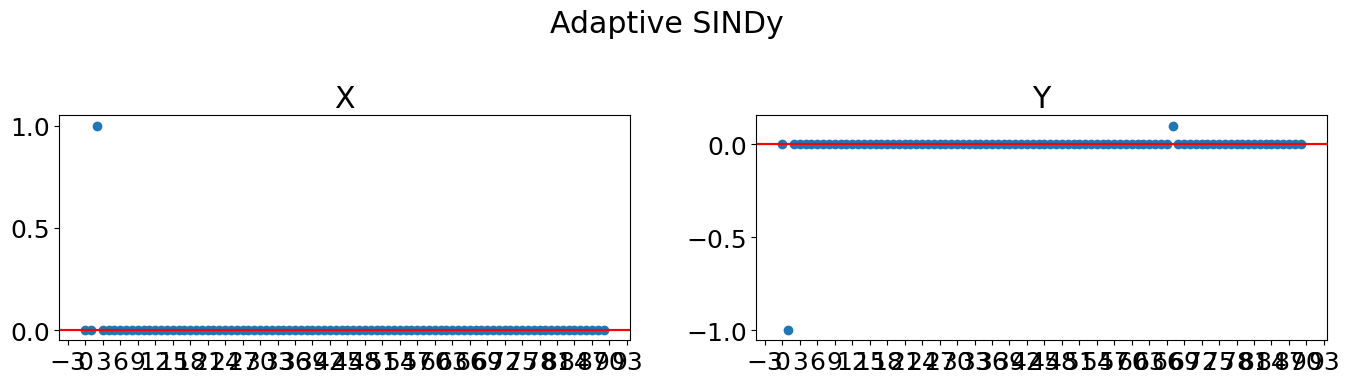

In [10]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o') 
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o') 
ax[1].set_title('Y')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()


In [15]:
print(COEFF_ADT[torch.nonzero(COEFF_ADT[:, 0]), 0])
print(COEFF_ADT[torch.nonzero(COEFF_ADT[:, 1]), 1])
print(XCOSINE_ADT[:, 1])

tensor([[1.]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([[-1.0000],
        [ 0.1000]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([1.6279, 0.7500, 0.6188, 1.1323, 0.8636, 1.1046], device='cuda:0',
       grad_fn=<SelectBackward0>)
